In [ ]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import Counter 
from datetime import datetime, timedelta
from IPython.core.display import HTML
from pymystem3 import Mystem

In [ ]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-07-21 17:33:17--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2022-07-21 17:33:18--  http://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)... 37.140.137.3, 2a02:6b8:0:2221::303
Connecting to cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)|37.140.137.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.5’

mystem-3.0-linux3.1 100%[===

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
m = Mystem()

# Анализ рынка труда по данным hh.ru

В данной работе проанализируем вакансии Аналитик, Дендролог, Тестировщик, Конструктор, Учитель математики за июнь 2022 года.

## Получение данных по API

Используем API: https://github.com/hhru/api

- Пример поиска вакансии: https://hh.ru/search/vacancy?area=1679&experience=between1And3&search_field=name&search_field=company_name&search_field=description&text=SEO-специалист&clusters=true&enable_snippets=true&from=cluster_experience  
- Пример JSON запроса: https://api.hh.ru/vacancies?text="Аналитик"&date_from=2022-07-04&date_to=2022-07-11&responses_count_enabled=True&per_page=100&page=1

## Создание функций

#### Общая функция для парсинга

In [ ]:
def hh_get_vacancy(job_name, search_days):
    
    # получение данных
    GET = "https://api.hh.ru/"
    dt_now = datetime.now().date()
    dt_from = dt_now - timedelta(days = search_days)
    DATE_TO = dt_now.isoformat() #API в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
    DATE_FROM = dt_from.isoformat()

    # формирование запроса
    VAC_URL = GET + f'vacancies?text={job_name}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

    # создание пустого датафрейма
    df_vacancy = pd.DataFrame() 

    # добавление опыта работы
    experiences = ['noExperience', 'between1And3', 'between3And6', 'moreThan6']
    for exp in experiences:
        page = 0
        url = VAC_URL + f'&experience={exp}'
        try:
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
            items = data['items']
            for page in range(1, data ['pages']):
                r = requests.get(url + f'&page={page}')
                data = json.loads(r.text)
                items += data['items']
            df = pd.DataFrame(items)
            df['experience'] = exp
            df_vacancy = pd.concat([df_vacancy, df])
        except Exception as e:
            print(exp, '-',e)
            time.sleep(5)

    # работа со словарем JSON
    def return_id(x, key='id', nan_value=np.nan):
        try:
            return x[key]
        except Exception as e:
            return nan_value

    # добавим нужные признаки
    df_vacancy['employer_name'] = df_vacancy['employer'].apply(return_id, key='name') # наименование работодателя
    df_vacancy['department_name'] = df_vacancy['department'].apply(return_id, key='name') # наименование депортамента, отдела
    df_vacancy['salary_from'] = df_vacancy['salary'].apply(return_id, key='from') # зп от
    df_vacancy['salary_to'] = df_vacancy['salary'].apply(return_id, key='to') # зп до
    df_vacancy['city'] = df_vacancy['area'].apply(return_id, key='name') # город
    df_vacancy['metro_name'] = df_vacancy['address'].apply(return_id, key='metro') # название метро
    df_vacancy['station_name'] = df_vacancy['metro_name'].apply(return_id, key='station_name') # название метро
    df_vacancy['line_name'] = df_vacancy['metro_name'].apply(return_id, key='line_name') # наименование линии
    df_vacancy['address_street'] = df_vacancy['address'].apply(return_id, key='street') # адресс работодателя
    df_vacancy['responses'] = df_vacancy['counters'].apply(return_id, key='responses') # страна
    df_vacancy['requirement'] = df_vacancy['snippet'].apply(return_id, key='requirement') # требование

    # удалим мусорные значения
    df_vacancy['requirement'] = df_vacancy['requirement'].replace('<highlighttext>','', regex=True)
    df_vacancy['requirement'] = df_vacancy['requirement'].replace('</highlighttext>','', regex=True)

    # фильтруем датафрейм
    df_vacancy = df_vacancy[['id', 'name', 'has_test',
          'response_letter_required', 'published_at',
            'url', 'alternate_url', 'contacts',
          'experience', 'employer_name', 'department_name', 'salary_from',
          'salary_to', 'city', 'station_name', 'line_name',
          'address_street', 'responses', 'requirement']]

    # проведем лемматизацию данных
    all_string_requirement = []
    for i in range(len(df_vacancy['requirement'].unique())):
      try:
        all_string_requirement += df_vacancy['requirement'].unique()[i].split(' ')
      except:
        i += 1
    string = ''.join(str(all_string_requirement)) 
    lemmas = m.lemmatize(string) # вызовем функцию Mystem для строки со значениями из 'purpose'
    df_lemma_count = pd.DataFrame.from_dict(Counter(lemmas), orient='index').reset_index().sort_values(by=0, ascending=False)
    df_top_ru = df_lemma_count[df_lemma_count['index'].str.match(r'[а-яА-Я]{5,30}')].head(50)
    df_top_en = df_lemma_count[df_lemma_count['index'].str.match(r'[a-zA-Z]{3,30}')].head(50)
    
    return df_vacancy, df_top_ru, df_top_en

### Парсинг и получения таблиц

In [ ]:
def parse_vanacy_name(text_name_vacancy, days_number):
  df, df_lemma_ru, df_lemma_en = hh_get_vacancy(text_name_vacancy, days_number)
  df_msk = df[df.loc[:,"city"].isin(["Москва"])] # Выбор вакансии только по г.Москва
  df_msk_3_years = df_msk.copy()
  df_msk_3_years = df_msk[df_msk.loc[:,"experience"].isin(["noExperience", "between1And3"])] # Выбор вакансии только по опыту работы до 3-х лет
  return df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years

### Топ наименований должностей

In [ ]:
def top_proff(data, number):
  name = (data['name']).value_counts().head(number)
  plt.figure(figsize=(15, 5))
  sns.barplot(y=name.index,x=name)
  plt.xlabel('Количество вакансий')
  plt.ylabel('Название должности', fontsize=11)
  plt.title(f'Топ-{number} наименований должностей', fontsize=16)
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Топ должностей по ЗП

In [ ]:
def top_salary(data, number):
  salary_mean_n = data[data['salary_from']<500000].pivot_table(index='name', values='salary_from', aggfunc='median').sort_values(by='salary_from', ascending=False).head(number)
  plt.figure(figsize=(15, 5))
  sns.barplot(y=salary_mean_n.index,x=salary_mean_n['salary_from'])
  plt.title(f'Топ-{number} должностей по медианной зарплате')
  plt.ylabel("Название должности")
  plt.xlabel("Медианная зарплата")
  plt.xticks(rotation=90)
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Указана ЗП

In [ ]:
def with_salary(data):
  plt.figure(figsize=(5, 5))
  data['salary_from'].isna().value_counts(normalize=True).reset_index().replace(
      {True: 'Указана ЗП', False: 'Не указана ЗП'}).plot(kind='pie', y='salary_from', autopct='%1.0f%%', labels=['Не указана ЗП', 'Указана ЗП'], legend=None)
  plt.title(f'Количество вакансий с указанной заработной платой')
  plt.xticks(rotation=90)
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Топ городов по количеству вакансий

In [ ]:
def top_city(data, number):
  salary_mean_n = data.pivot_table(index='city', values='salary_from', aggfunc=('median', 'count')).sort_values(by='count', ascending=False).head(number)
  plt.figure(figsize=(15, 5))
  sns.barplot(y=salary_mean_n.index,x=salary_mean_n['count'])
  plt.title(f"Топ-{number} городов по количеству вакансий (Всего вакансий за период: {sum(salary_mean_n['count'])})")
  plt.ylabel("Город")
  plt.xlabel("Количество вакансий")
  plt.xticks(rotation=90)
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Топ компаний по медианной зарплате

In [ ]:
def top_company(data, number):
  salary_mean_emp = data[data['salary_from']<500000].pivot_table(index='employer_name', values='salary_from', aggfunc='median').sort_values(by='salary_from', ascending=False).head(number)
  plt.figure(figsize=(15, 5))
  sns.barplot(y=salary_mean_emp.index,x=salary_mean_emp['salary_from'])
  plt.title(f'Топ-{number} компаний по медианной зарплате')
  plt.ylabel("Название компании")
  plt.xlabel("Медианна зарплата")
  plt.xticks(rotation=90)
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Топ компани, вакансия, зп

In [ ]:
def table_top_salary_company(data, number):
  salary_max=pd.pivot_table(data[data['salary_from']<500000],
                index=['employer_name', 'name', 'alternate_url'],
                values=['salary_to'], aggfunc = 'max').sort_values(by='salary_to', ascending=False).reset_index()
  return salary_max.head(number)      

### Анти топ компани, вакансия, зп

In [ ]:
def table_antitop_salary_company(data, number):
  salary_max=pd.pivot_table(data,
                index=['employer_name', 'name', 'alternate_url'],
                values=['salary_to'], aggfunc = 'max').sort_values(by='salary_to', ascending=False).reset_index()
  return salary_max.tail(number)      

### Количество самых частых слов в требовании вакансии

In [ ]:
def top_words(data):
  plt.figure(figsize=(15, 5))
  sns.barplot(data=data.head(10), x=data['index'].head(10), y=0)
  plt.title('Количество самых частых слов в требовании вакансии')
  plt.ylabel('Количество слов, шт.')
  plt.xlabel('Слова')
  plt.grid(color='grey', axis='both', alpha=0.5)
  return plt.show()

### Диаграмма размаха минимальной указанной зарплат

In [ ]:
def tail_salary_boxplot(data):
  plt.rcParams['figure.figsize']=(20, 2)
  sns.boxplot(x=data['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)])
  plt.title(f"Диаграмма размаха минимальной указанной зарплаты, руб.")
  plt.grid(color='grey', axis='both', alpha=.8)
  plt.xticks(np.arange(data['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)].min(), 
                      (data['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)].max() + df['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)].max()/35), 
                        ((data['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)].max() - df['salary_from'][data['salary_from'] <= data['salary_from'].quantile(0.90)].min()) / 20)))
  return plt.show()

### Диаграмма размаха максимальной указанной зарплаты

In [ ]:
def top_salary_boxplot(data):
  plt.rcParams['figure.figsize']=(20, 2)
  sns.boxplot(x=data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)])
  plt.title(f"Диаграмма размаха максимальной указанной зарплаты, руб.")
  plt.grid(color='grey', axis='both', alpha=.8)
  plt.xticks(np.arange(data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)].min(), 
                      (data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)].max() + data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)].max()/35), 
                        ((data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)].max() - data['salary_to'][data['salary_to'] <= data['salary_to'].quantile(0.90)].min()) / 20)))
  return plt.show()

## Анализ данных

### Аналитик

In [ ]:
text_analyst = f"SQL NAME:('Аналитик' or 'Analyst' or 'BI' or 'Business Intelligence' or 'Data Scientist' or 'Data Analyst' or 'Системный/бизнес-аналитик' or 'Системный аналитик')"

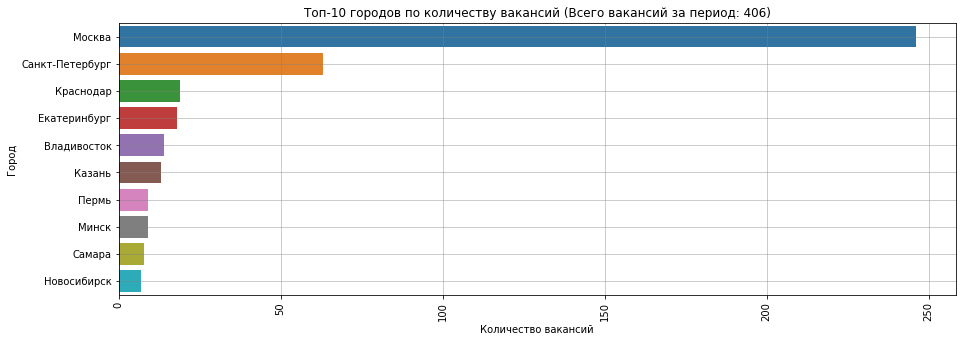

<Figure size 360x360 with 0 Axes>

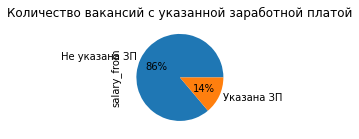

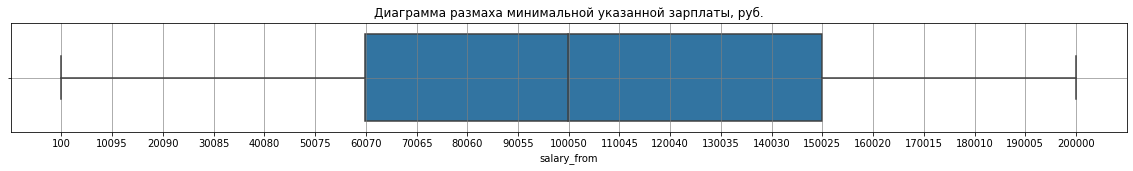

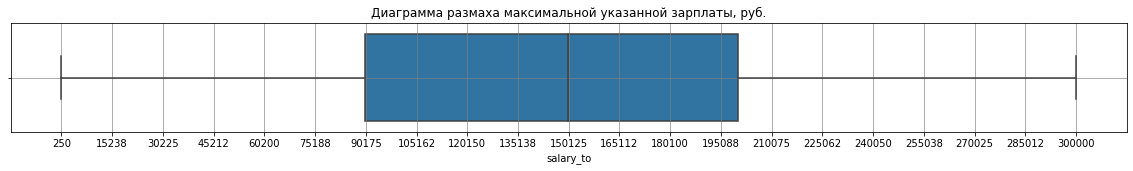

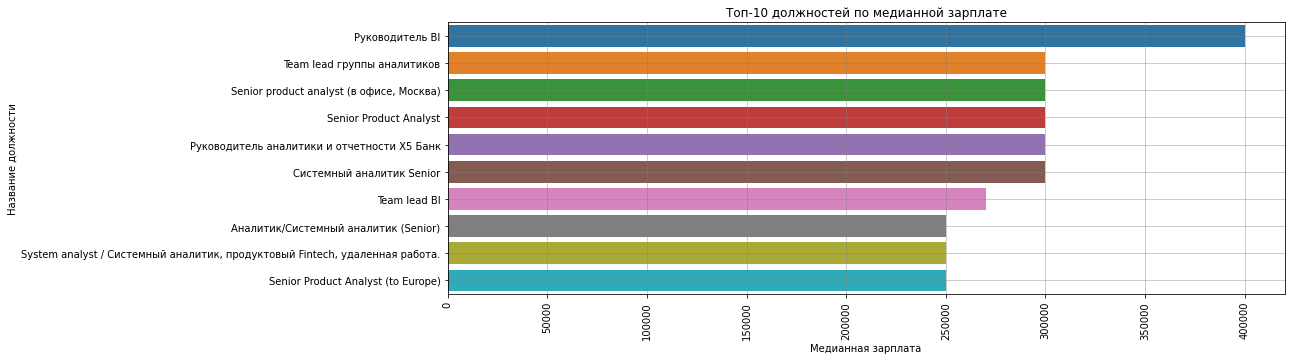

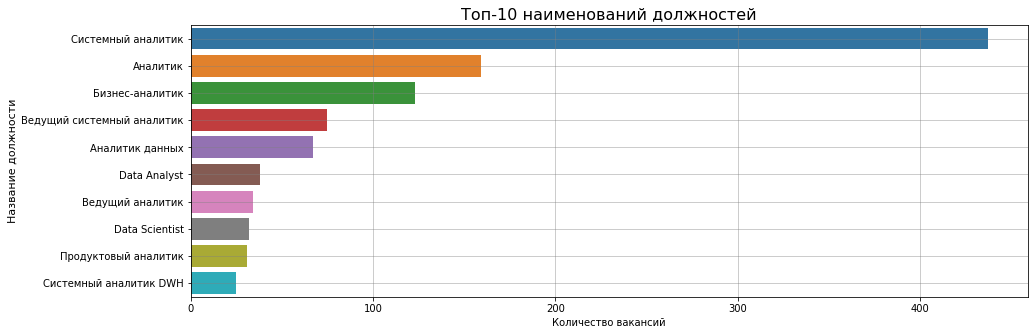

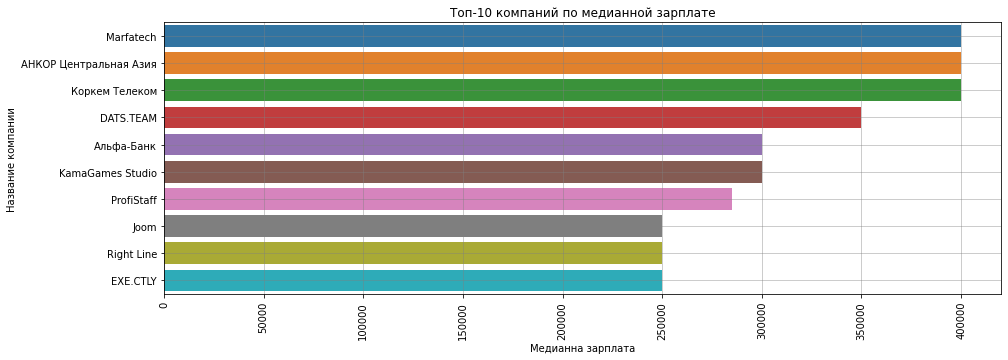

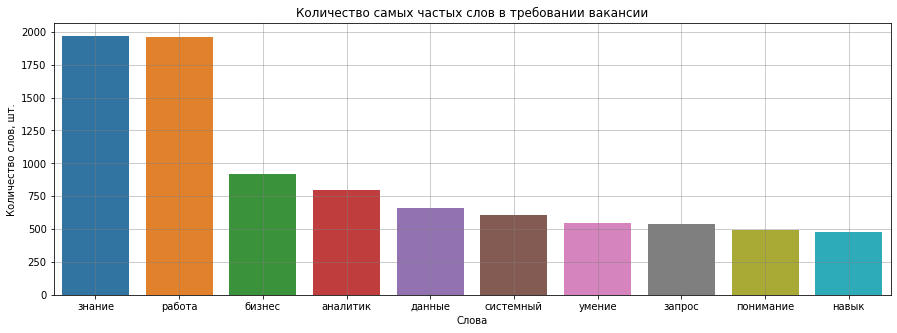

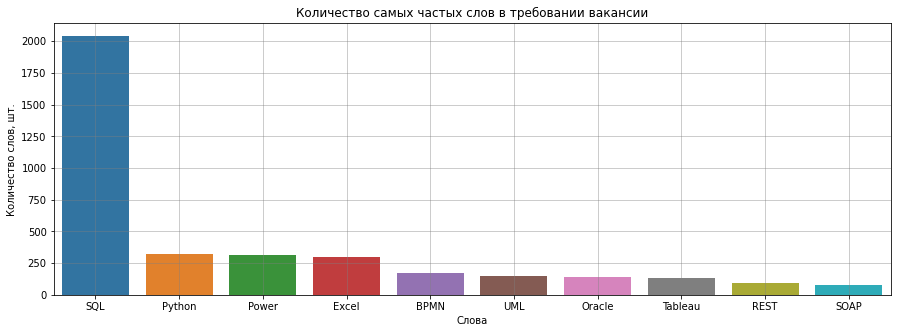

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,АНКОР Центральная Азия,Системный аналитик,https://hh.ru/vacancy/67433477,800000.0
1,Коркем Телеком,Системный аналитик,https://hh.ru/vacancy/67872335,600000.0
2,Marfatech,Руководитель BI,https://hh.ru/vacancy/67552159,500000.0
3,ProfiStaff,Ведущий аналитик,https://hh.ru/vacancy/67702365,500000.0
4,РТ КИС,Ведущий системный аналитик (senior/middle),https://hh.ru/vacancy/66930328,400000.0
5,АЙТИ.СПЕЙС,Системный аналитик (интеграции),https://hh.ru/vacancy/67497742,350000.0
6,ProfiStaff,Team lead BI,https://hh.ru/vacancy/67716643,350000.0
7,РТ КИС,Бизнес аналитик IT (midl/senior),https://hh.ru/vacancy/66930360,350000.0
8,АЙТИ.СПЕЙС,Системный Аналитик (System Analyst),https://hh.ru/vacancy/67725509,350000.0
9,АЙТИ.СПЕЙС,Системный аналитик (DWH),https://hh.ru/vacancy/67499089,350000.0


Анти топ


,employer_name,name,alternate_url,salary_to
406,"Hi, Rockits!",Business analyst / Reseacher,https://hh.ru/vacancy/67878366,4000.0
407,App in the Air,Middle/Senior Data Scientist,https://hh.ru/vacancy/67541621,4000.0
408,ITSS,Data scientist (remote),https://hh.ru/vacancy/67133668,4000.0
409,Wanted,Системный аналитик,https://hh.ru/vacancy/67696768,3800.0
410,Finstar Financial Group,System analyst (Vietnam),https://hh.ru/vacancy/67021109,3500.0
411,Finstar Financial Group,Data analyst Colombia,https://hh.ru/vacancy/67143645,3000.0
412,INSANE TECH,Business Data Analyst,https://hh.ru/vacancy/67760317,2000.0
413,MVK Technologies,Webmaster - Аналитик,https://hh.ru/vacancy/67764699,1400.0
414,Саппорт 24,Webmaster/ Аналитик,https://hh.ru/vacancy/67729279,1300.0
415,ФинТех,Аналитик бизнес-процессов,https://hh.ru/vacancy/66767257,250.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(text_analyst, 30)
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_analyst.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

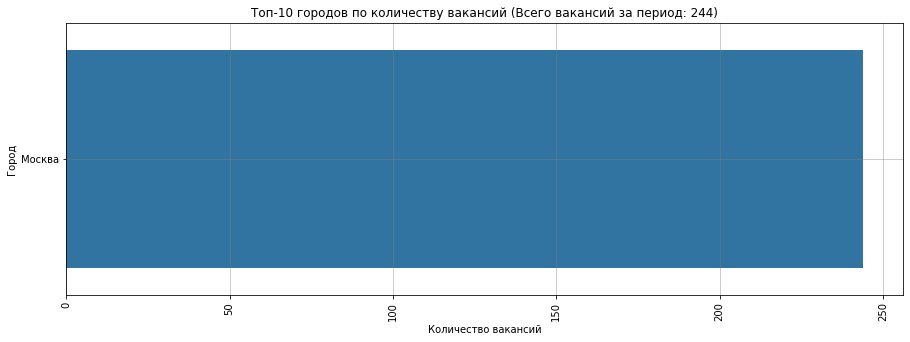

<Figure size 360x360 with 0 Axes>

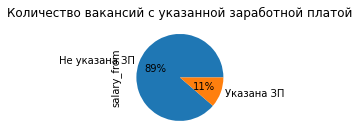

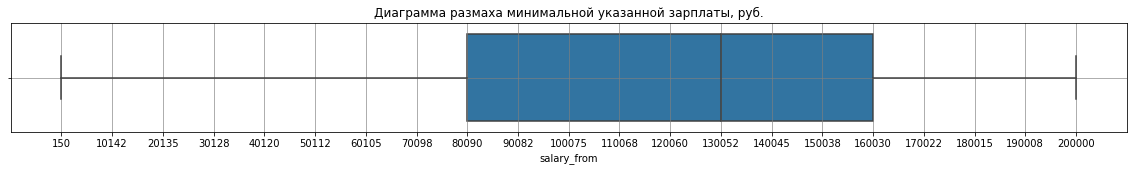

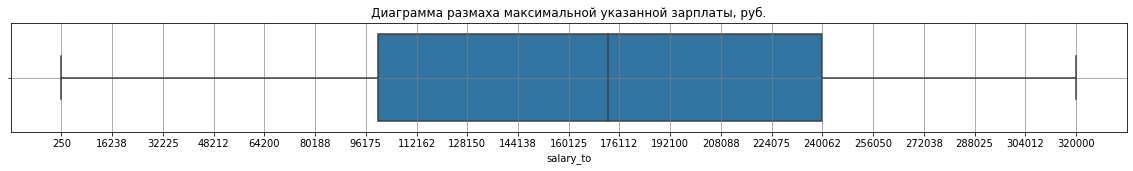

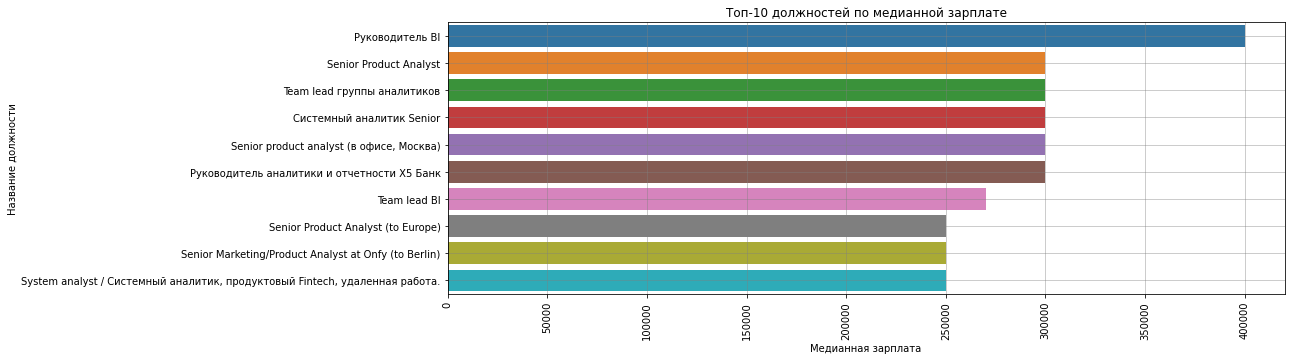

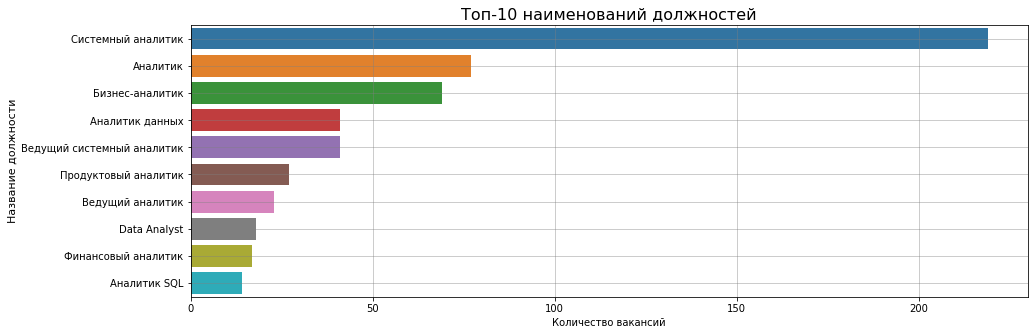

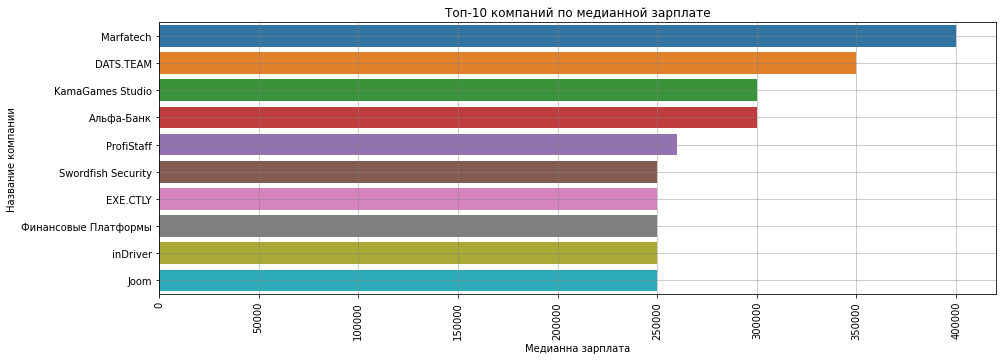

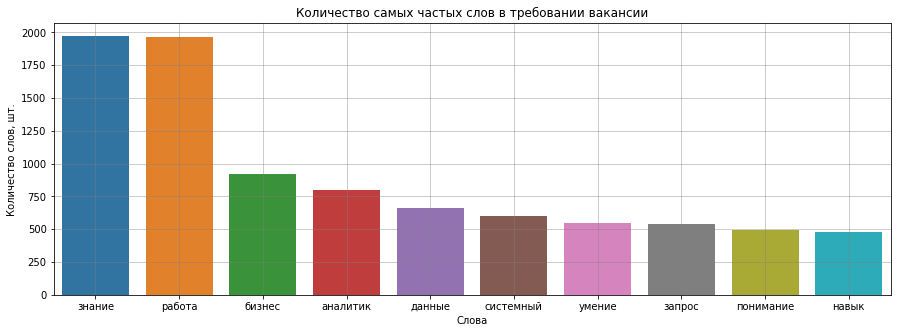

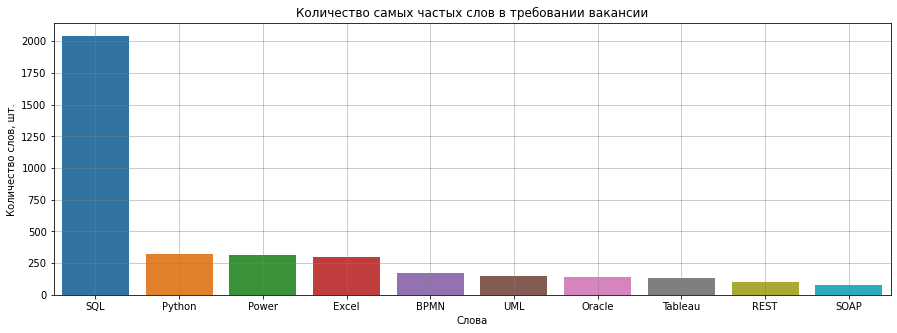

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,ProfiStaff,Ведущий аналитик,https://hh.ru/vacancy/67702365,500000.0
1,Marfatech,Руководитель BI,https://hh.ru/vacancy/67552159,500000.0
2,РТ КИС,Ведущий системный аналитик (senior/middle),https://hh.ru/vacancy/66930328,400000.0
3,АЙТИ.СПЕЙС,Системный аналитик (DWH),https://hh.ru/vacancy/67499089,350000.0
4,АЙТИ.СПЕЙС,Системный Аналитик (System Analyst),https://hh.ru/vacancy/67725509,350000.0
5,АЙТИ.СПЕЙС,Системный Аналитик (Middle),https://hh.ru/vacancy/67503491,350000.0
6,АЙТИ.СПЕЙС,Ведущий системный аналитик,https://hh.ru/vacancy/67502022,350000.0
7,Цифровая мастерская,Архитектор Данных (Системный аналитик/Бизнес аналитик),https://hh.ru/vacancy/68028667,350000.0
8,АЙТИ.СПЕЙС,Аналитик (системный),https://hh.ru/vacancy/67736897,350000.0
9,АЙТИ.СПЕЙС,Системный аналитик (интеграции),https://hh.ru/vacancy/67497742,350000.0


Анти топ


,employer_name,name,alternate_url,salary_to
208,Finstar Financial Group,Senior Scoring analyst Mexico,https://hh.ru/vacancy/67102994,4500.0
209,"Hi, Rockits!",Business / System analyst (с релокацией!),https://hh.ru/vacancy/67466860,4000.0
210,"Hi, Rockits!",Business analyst / Reseacher,https://hh.ru/vacancy/67878366,4000.0
211,Coin Liquidity Solutions,Product analyst,https://hh.ru/vacancy/67082971,4000.0
212,App in the Air,Middle/Senior Data Scientist,https://hh.ru/vacancy/67541621,4000.0
213,ITSS,Data scientist (remote),https://hh.ru/vacancy/67133668,4000.0
214,Wanted,Системный аналитик,https://hh.ru/vacancy/67696768,3800.0
215,Finstar Financial Group,System analyst (Vietnam),https://hh.ru/vacancy/67021109,3500.0
216,Finstar Financial Group,Data analyst Colombia,https://hh.ru/vacancy/67143645,3000.0
217,ФинТех,Аналитик бизнес-процессов,https://hh.ru/vacancy/66767257,250.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(text_analyst, 30)
df = df[df['city'] == 'Москва']
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_analyst_msk.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

### Дендролог

In [ ]:
dendrolog = f"'Дендролог' or 'Инженер дендролог' or 'Инженер-дендролог' or 'dendrolog' or 'Ландшафтный архитектор' or 'Инженер-эколог'"

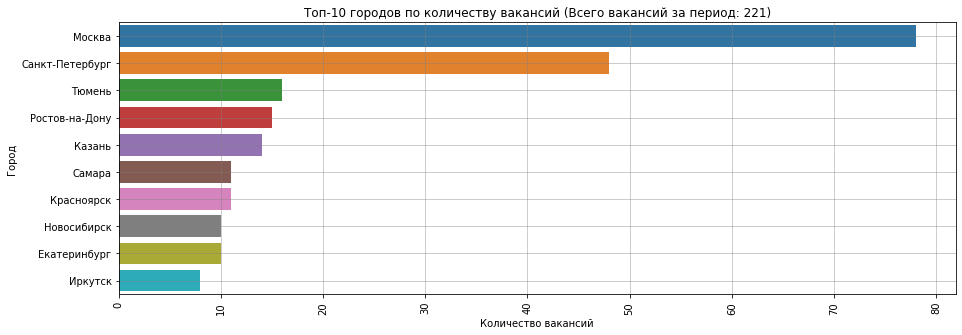

<Figure size 360x360 with 0 Axes>

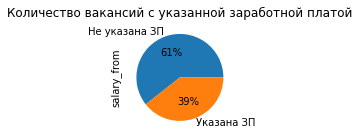

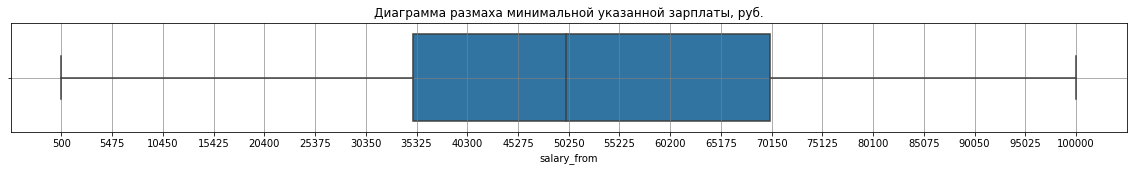

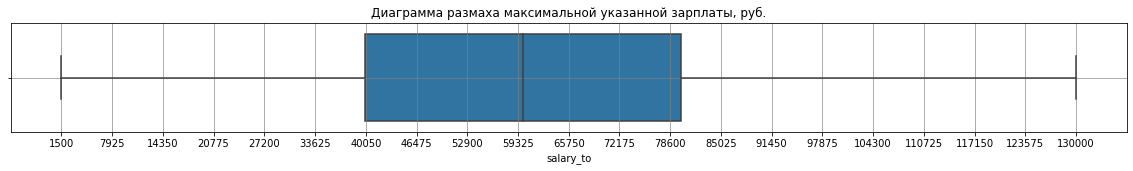

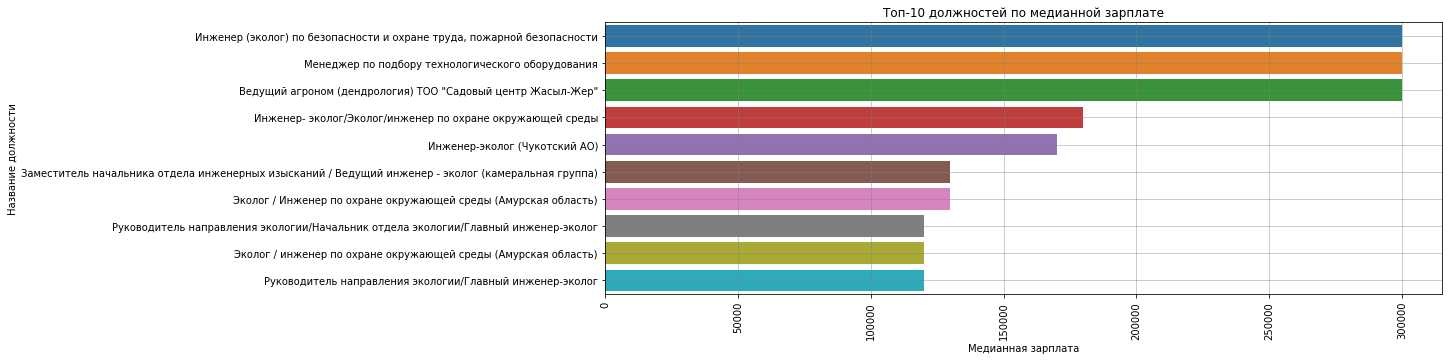

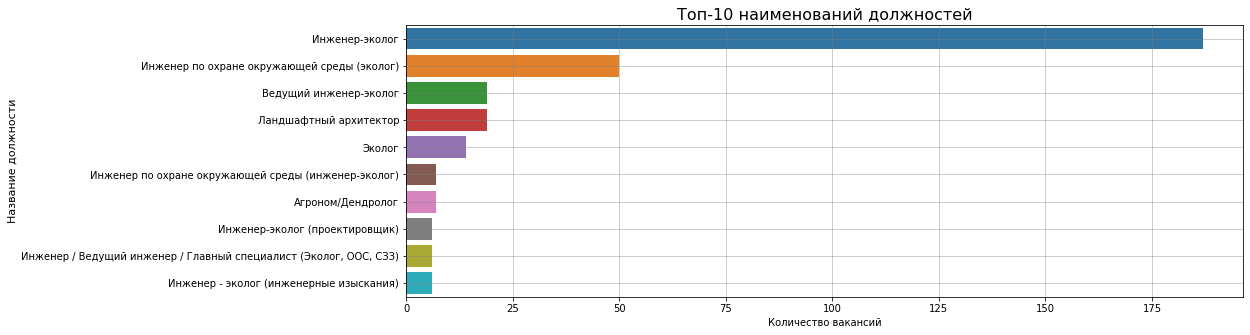

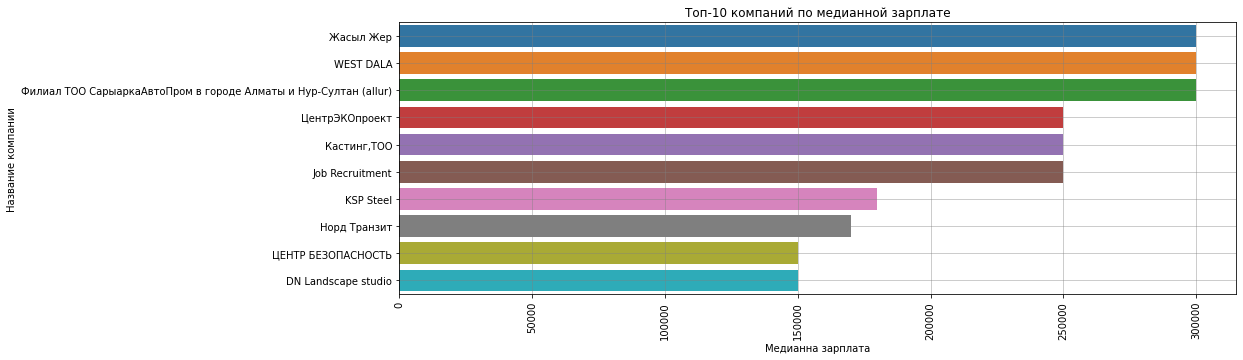

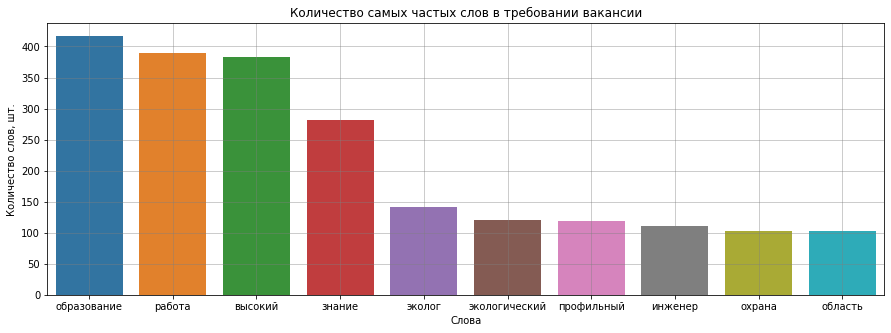

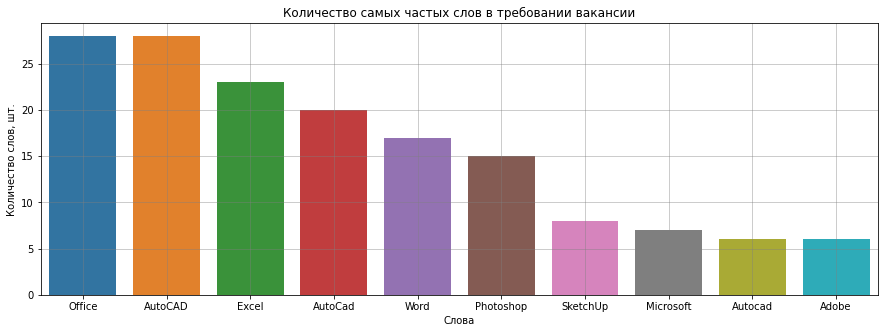

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,Жасыл Жер,"Ведущий агроном (дендрология) ТОО ""Садовый центр Жасыл-Жер""",https://hh.ru/vacancy/67230772,350000.0
1,DN Landscape studio,Архитектор,https://hh.ru/vacancy/67085611,300000.0
2,Филиал ТОО СарыаркаАвтоПром в городе Алматы и Нур-Султан (allur),"Инженер (эколог) по безопасности и охране труда, пожарной безопасности",https://hh.ru/vacancy/67439703,300000.0
3,WEST DALA,Менеджер по подбору технологического оборудования,https://hh.ru/vacancy/67783574,300000.0
4,Selecta,Руководитель проекта (продажи),https://hh.ru/vacancy/53835305,250000.0
5,НИЛ,Инженер-эколог (проектировщик),https://hh.ru/vacancy/52312373,250000.0
6,GetResult,Региональный менеджер по продажам,https://hh.ru/vacancy/67820997,250000.0
7,Мегаполис Про,Менеджер по продажам (строительные и ландшафтные материалы),https://hh.ru/vacancy/67259727,200000.0
8,ЛюксСад,Прораб по ландшафтным работам/Руководитель объекта,https://hh.ru/vacancy/67985753,200000.0
9,Геоэкосервис,Инженер-эколог,https://hh.ru/vacancy/67874916,200000.0


Анти топ


,employer_name,name,alternate_url,salary_to
224,"МАГНИТ, Розничная сеть",Инженер-эколог,https://hh.ru/vacancy/66493468,25800.0
225,"МАГНИТ, Розничная сеть",Инженер-эколог,https://hh.ru/vacancy/67473469,25400.0
226,Центр Экологии Человека,Инженер-эколог (проектировщик),https://hh.ru/vacancy/67783075,25000.0
227,Пермнефтеотдача,Инженер-эколог,https://hh.ru/vacancy/67792923,25000.0
228,ГБУ АО Служба спасения им.И.А.Поливаного,Инженер по охране окружающей среды (эколог),https://hh.ru/vacancy/67572639,25000.0
229,Эко Союз,Помощник инженера-эколога (младший эколог),https://hh.ru/vacancy/67609630,22000.0
230,"МАГНИТ, Розничная сеть",Инженер-эколог,https://hh.ru/vacancy/66114190,15876.0
231,Московский политехнический университет,Инженер-эколог,https://hh.ru/vacancy/67247457,15000.0
232,Гронда Систем,Инженер по охране труда и экологии,https://hh.ru/vacancy/67680638,1500.0
233,ГП Управляющая компания холдинга Белорусская цементная компания,"Инженер (охрана труда, пожарная безопасность, экология, энергетика)",https://hh.ru/vacancy/67793283,1500.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(dendrolog, 30)
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_dendrolog.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

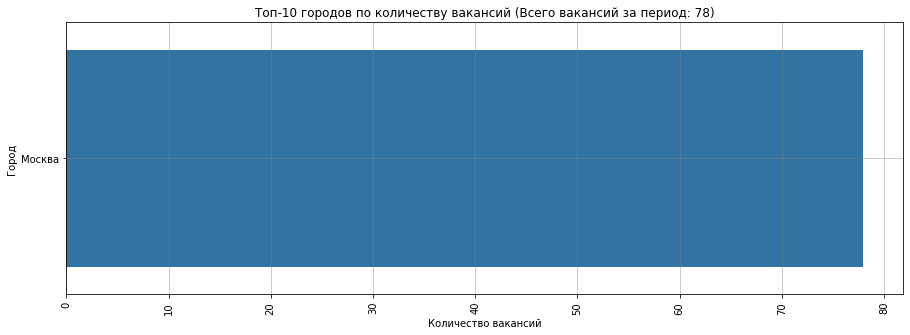

<Figure size 360x360 with 0 Axes>

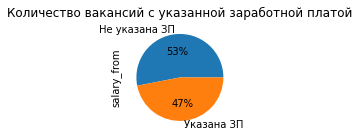

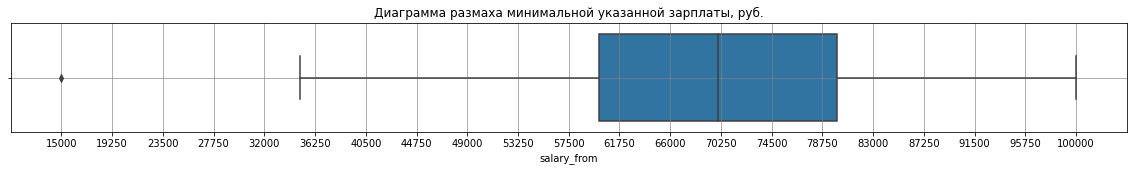

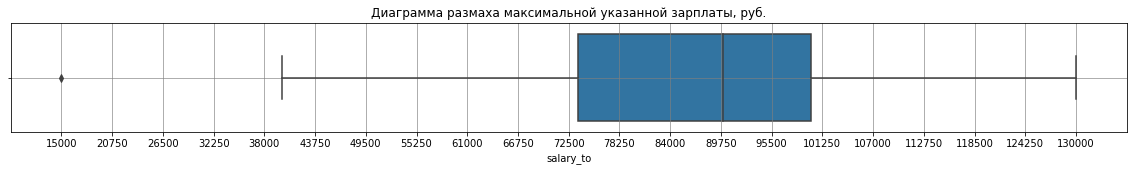

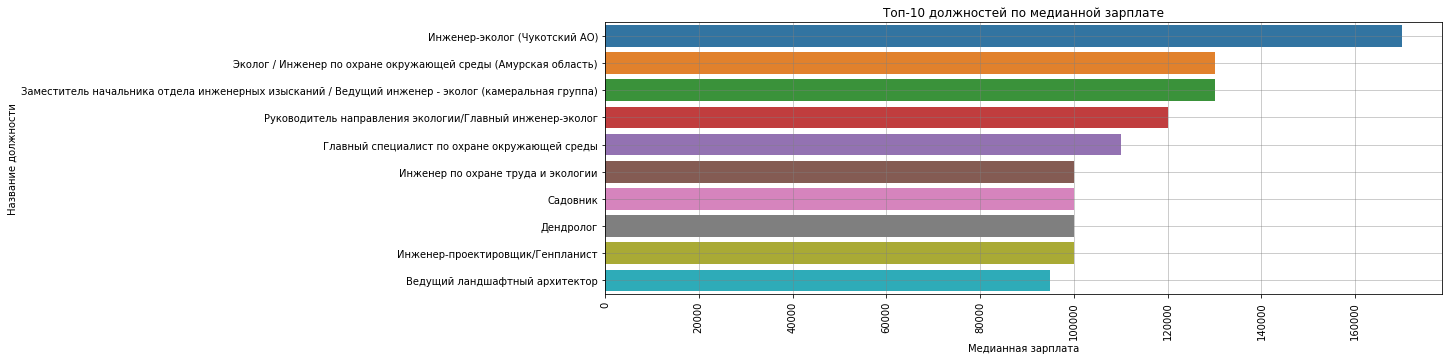

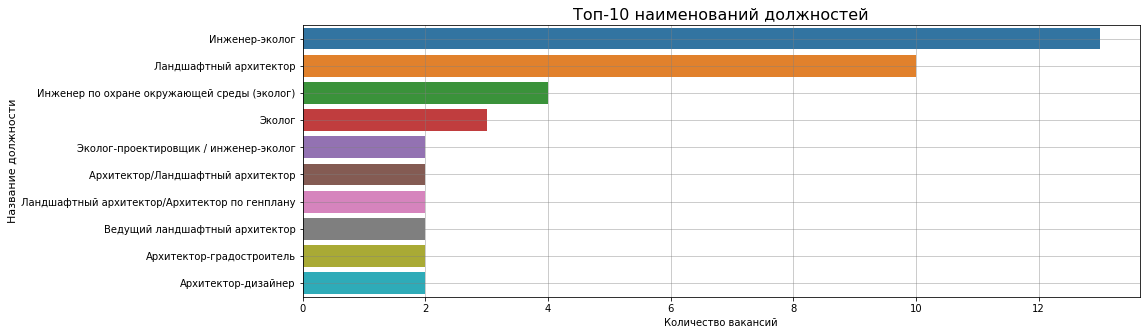

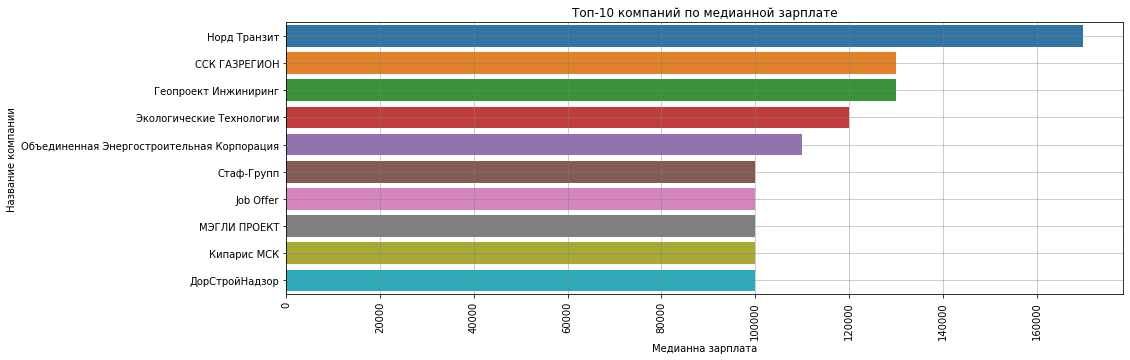

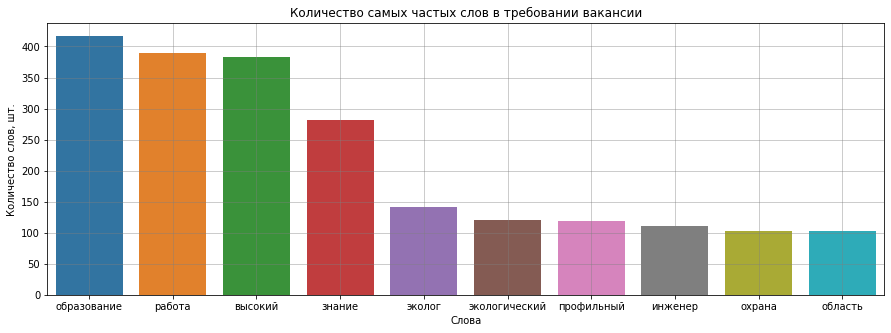

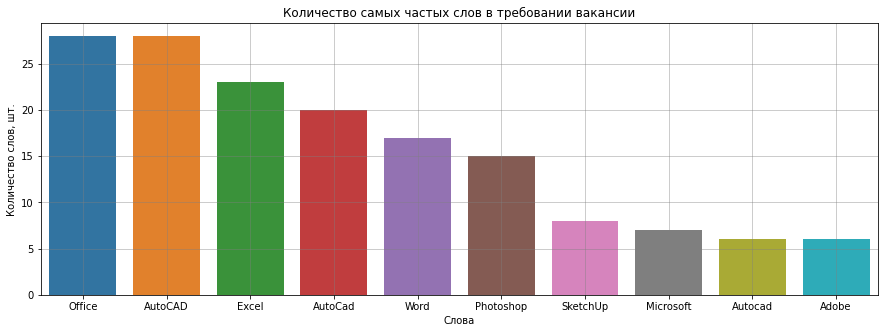

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,GetResult,Региональный менеджер по продажам,https://hh.ru/vacancy/67820997,250000.0
1,Selecta,Руководитель проекта (продажи),https://hh.ru/vacancy/53835305,250000.0
2,Мегаполис Про,Менеджер по продажам (строительные и ландшафтные материалы),https://hh.ru/vacancy/67259727,200000.0
3,ЛюксСад,Прораб по ландшафтным работам/Руководитель объекта,https://hh.ru/vacancy/67985753,200000.0
4,Экологические Технологии,Руководитель направления экологии/Главный инженер-эколог,https://hh.ru/vacancy/67443961,150000.0
5,Филиал ФБУЗ ЦГИЭ на водном транспорте,Химик-эксперт аналитической лаборатории (Врач по санитарно-гигиеническим лабораторным исследованиям),https://hh.ru/vacancy/67075668,130000.0
6,Европарк,Ведущий ландшафтный архитектор,https://hh.ru/vacancy/67654194,130000.0
7,ДорСтройНадзор,Инженер по охране труда и экологии,https://hh.ru/vacancy/67299898,120000.0
8,Группа Компаний Фабрика дверей «Porta prima»,"Менеджер-консультант в салон (СТК ""Твой дом"" Вегас, м. Домодедовская)",https://hh.ru/vacancy/67977248,120000.0
9,Объединенная Энергостроительная Корпорация,Главный специалист по охране окружающей среды,https://hh.ru/vacancy/55201192,110000.0


Анти топ


,employer_name,name,alternate_url,salary_to
41,ГБУ ГлавАПУ,Эколог,https://hh.ru/vacancy/67912069,70000.0
42,ГБУ Ритуал,Инженер по охране окружающей среды (эколог),https://hh.ru/vacancy/67345476,70000.0
43,Новая Усадьба - Сады и Парки,Ландшафтный архитектор/дизайнер по ландшафту,https://hh.ru/vacancy/67814955,60000.0
44,Российская академия народного хозяйства и государственной службы при Президенте Российской Федерации,Инженер первой категории (Эколог),https://hh.ru/vacancy/67778762,60000.0
45,ГАУК г.Москвы Усадьба Воронцово,Инженер-эколог (инженер отдела благоустройства),https://hh.ru/vacancy/67347319,60000.0
46,ГБУ ГлавАПУ,Проектировщик по водоснабжению/водоотведению,https://hh.ru/vacancy/50115395,60000.0
47,ГКУ города Москвы Центр занятости населения города Москвы,Инженер по охране окружающей среды (эколог)/Эколог по работе с договорами на вывоз ТКО,https://hh.ru/vacancy/68023028,55000.0
48,Dot and Dash Archirects,Архитектор-дизайнер,https://hh.ru/vacancy/67382991,50000.0
49,ФГАУ Оздоровительный комплекс «Рублёво-Успенский» Управления делами Президента Российской Федерации,Инженер по охране окружающей среды (инженер-эколог),https://hh.ru/vacancy/51026011,40000.0
50,Московский политехнический университет,Инженер-эколог,https://hh.ru/vacancy/67247457,15000.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(dendrolog, 30)
df = df[df['city'] == 'Москва']
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_dendrolog_msk.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

### QA инженер

In [ ]:
qa_engineer = f"SQL NAME:('QA инженер' or 'QA-инженер' or 'QA Engineer ' or 'QA-Engineer' or 'Специалист по тестированию' or 'Тестировщик ручной' or 'QA engineer manual')"

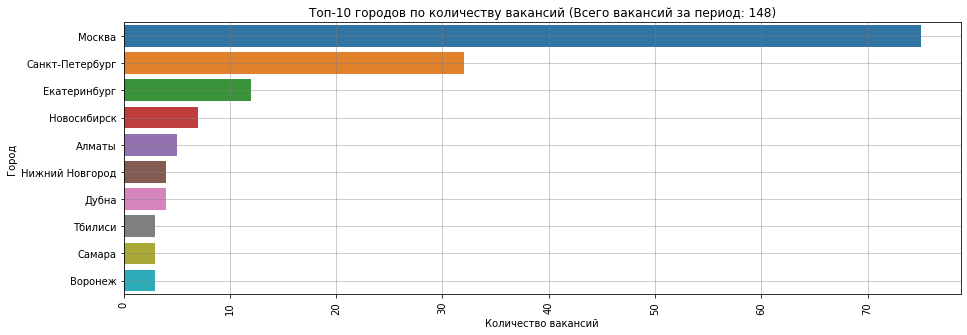

<Figure size 360x360 with 0 Axes>

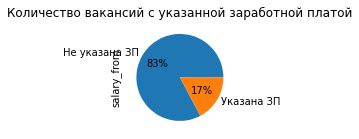

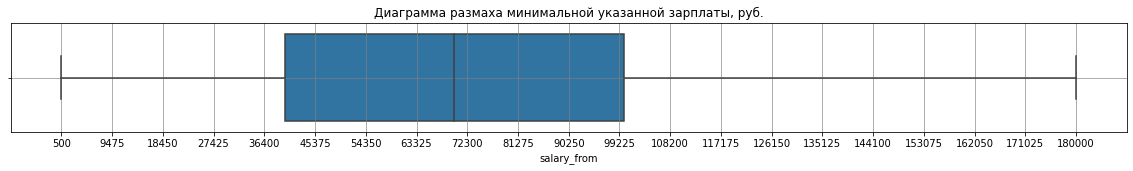

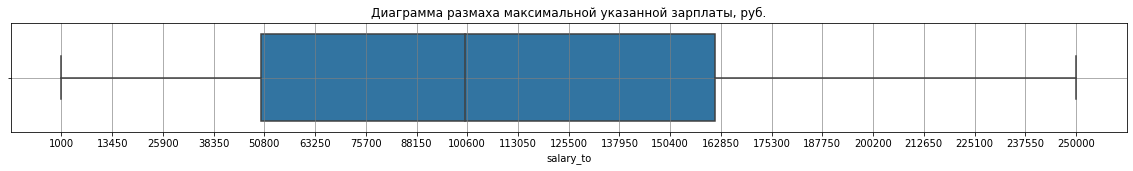

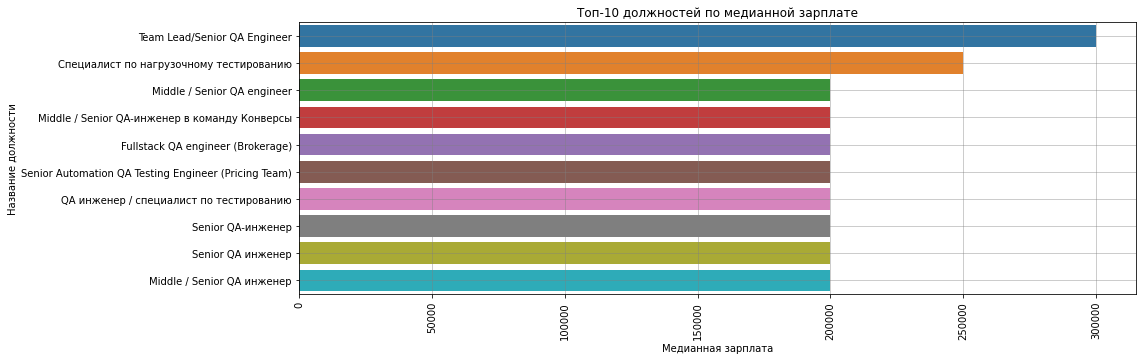

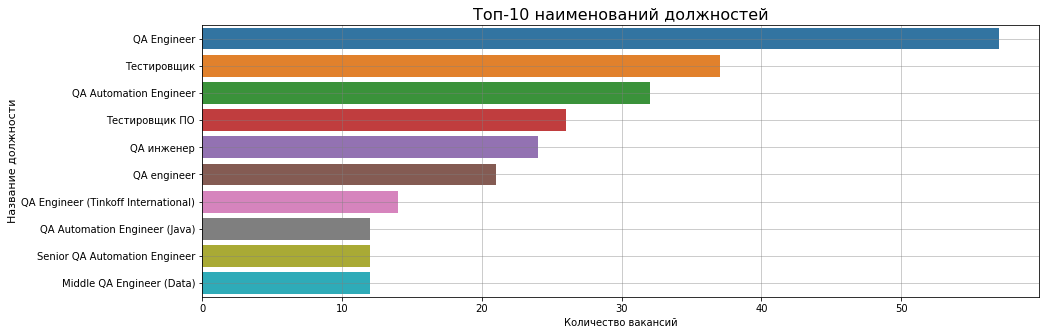

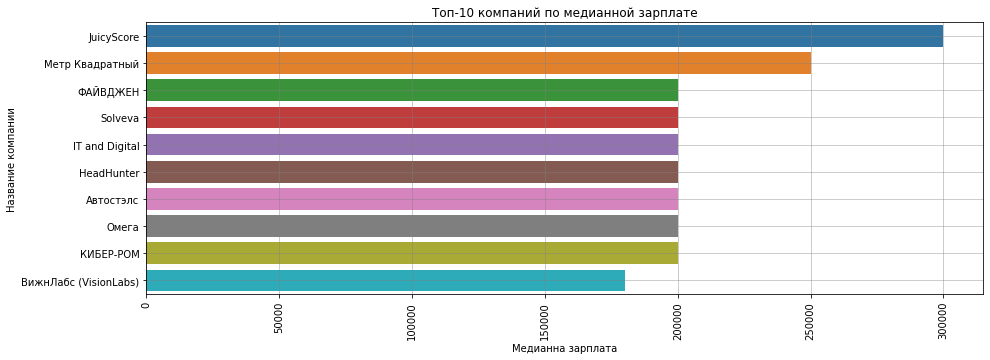

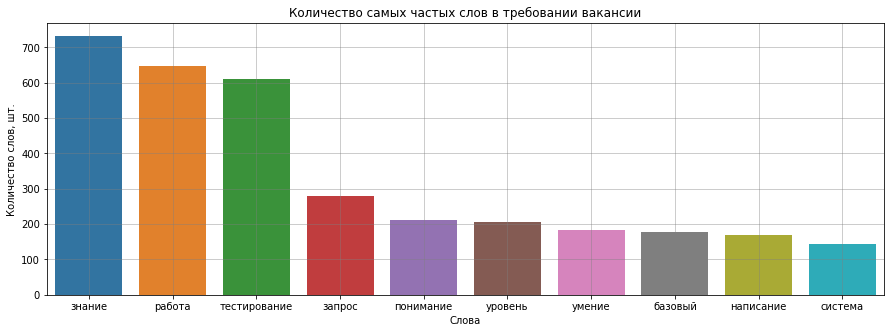

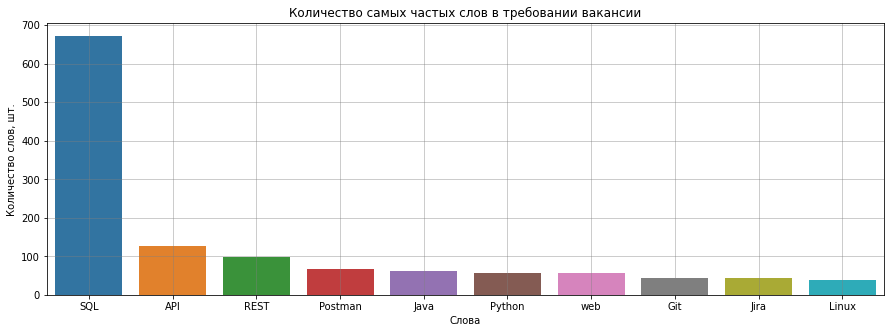

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,Омега,QA Engineer,https://hh.ru/vacancy/67762500,700000.0
1,АЙТИ.СПЕЙС,Тестировщик Siebel,https://hh.ru/vacancy/67975664,300000.0
2,Solveva,Senior Automation QA Testing Engineer (Pricing Team),https://hh.ru/vacancy/67874919,300000.0
3,СБЕР,Fullstack QA engineer (Brokerage),https://hh.ru/vacancy/67156596,300000.0
4,Тагес Джамп,Middle Automation QA Инженер (Москва),https://hh.ru/vacancy/67342664,290000.0
5,L’etoile Digital,"Senior QA Инженер (удаленно-тестирование мобильных приложений (iOS, Android)",https://hh.ru/vacancy/67035687,270000.0
6,Тагес Джамп,Middle Automation QA Инженер (Санкт-Петербург),https://hh.ru/vacancy/54852489,270000.0
7,Employcity,QA Automation Engineer,https://hh.ru/vacancy/67228399,270000.0
8,Lenkep recruitment,QA Engineer,https://hh.ru/vacancy/67763690,250000.0
9,Right Line,Тестировщик-автоматизатор (QA automation engineer),https://hh.ru/vacancy/66663788,250000.0


Анти топ


,employer_name,name,alternate_url,salary_to
155,Social Discovery Ventures,Middle+/Senior QA Engineer,https://hh.ru/vacancy/67656032,3000.0
156,Social Discovery Ventures,Senior Mobile QA Engineer,https://hh.ru/vacancy/67600383,3000.0
157,LATOKEN,DeFi Wallet QA Engineer,https://hh.ru/vacancy/67409651,2500.0
158,LATOKEN,DeFi Wallet QA Engineer,https://hh.ru/vacancy/67409652,2500.0
159,Crassula,QA Engineer,https://hh.ru/vacancy/67895701,2000.0
160,FEST agency,QA-engineer,https://hh.ru/vacancy/67136099,1500.0
161,Большой Город - Софт,Middle QA engineer,https://hh.ru/vacancy/67511422,1350.0
162,Lightspeed,Junior QA Engineer (Manual),https://hh.ru/vacancy/66530571,1300.0
163,Lightspeed,Junior QA Engineer (Manual),https://hh.ru/vacancy/66530572,1300.0
164,Appsolute Media,Инженер QA,https://hh.ru/vacancy/66229878,1000.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(qa_engineer, 30)
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_qa_engineer.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

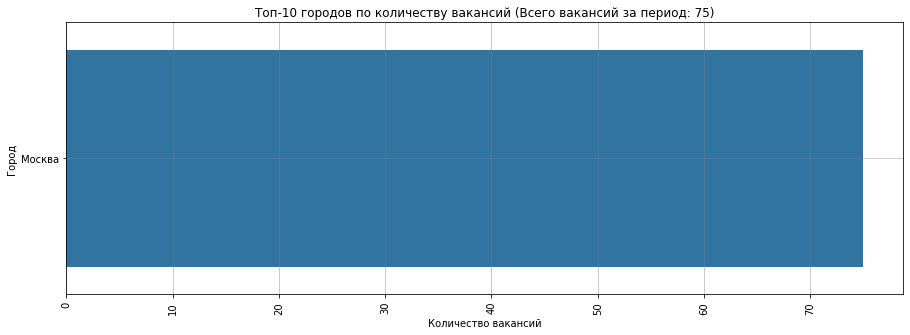

<Figure size 360x360 with 0 Axes>

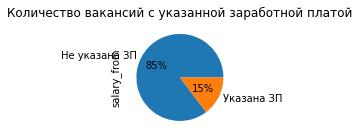

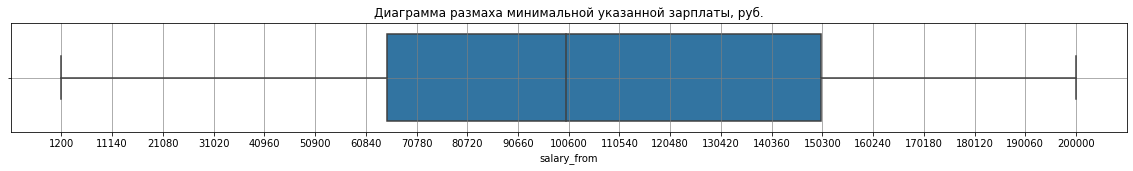

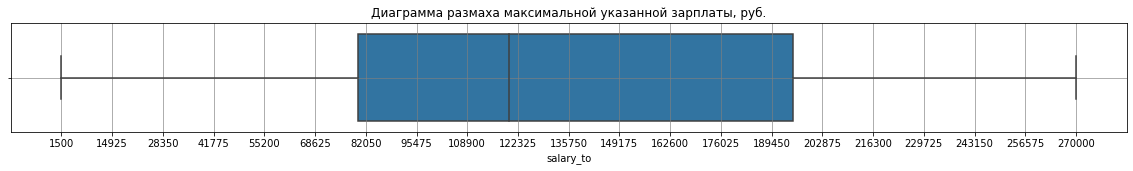

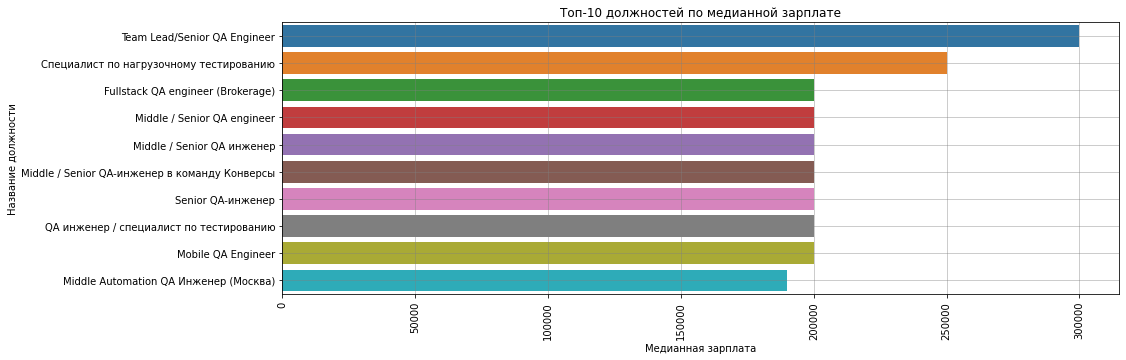

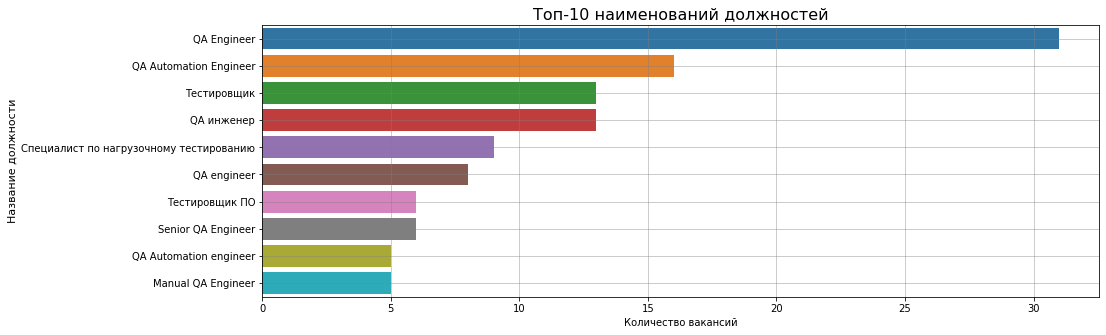

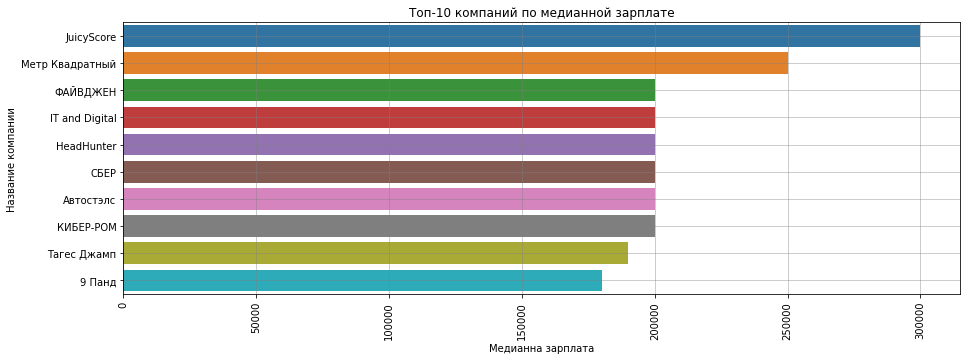

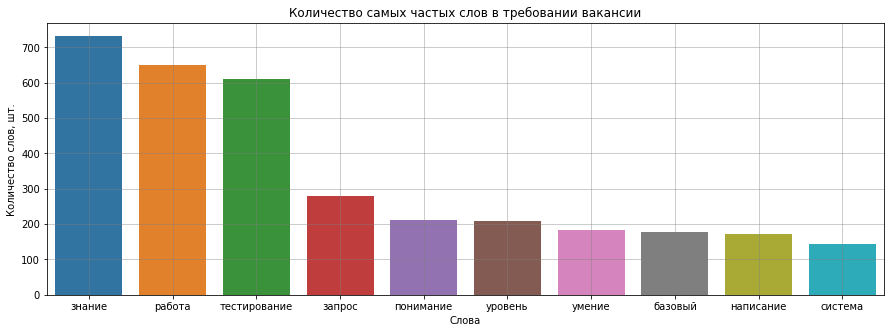

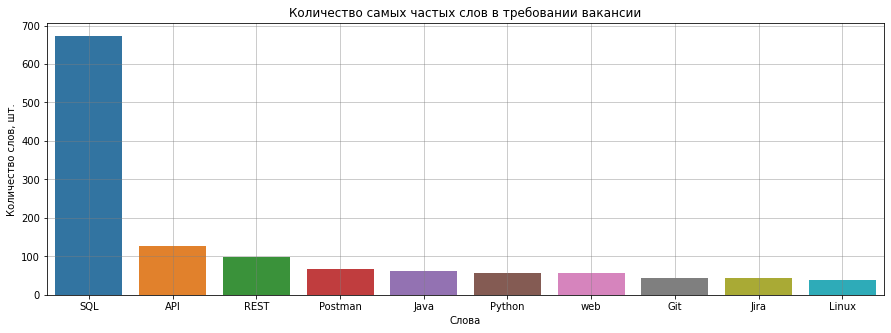

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,АЙТИ.СПЕЙС,Тестировщик Siebel,https://hh.ru/vacancy/67975664,300000.0
1,СБЕР,Fullstack QA engineer (Brokerage),https://hh.ru/vacancy/67156596,300000.0
2,Тагес Джамп,Middle Automation QA Инженер (Москва),https://hh.ru/vacancy/67342664,290000.0
3,L’etoile Digital,"Senior QA Инженер (удаленно-тестирование мобильных приложений (iOS, Android)",https://hh.ru/vacancy/67035687,270000.0
4,Employcity,QA Automation Engineer,https://hh.ru/vacancy/67228399,270000.0
5,Lenkep recruitment,QA Engineer,https://hh.ru/vacancy/67763690,250000.0
6,9 Панд,Middle/Senior QA инженер,https://hh.ru/vacancy/67746329,250000.0
7,Right Line,Тестировщик-автоматизатор (QA automation engineer),https://hh.ru/vacancy/66663788,250000.0
8,Employcity,QA Manual Engineer,https://hh.ru/vacancy/67728534,250000.0
9,Цифроматика,"QA Engineer (Manual, Load, Automation)",https://hh.ru/vacancy/67134096,250000.0


Анти топ


,employer_name,name,alternate_url,salary_to
59,EXNESS Global Limited,Senior QA Engineer (Automation),https://hh.ru/vacancy/67513153,4500.0
60,Wisebits,Senior QA Engineer (на Кипр),https://hh.ru/vacancy/67379945,4000.0
61,NGRServices,QA Automation - инженер/тестировщик (QA Engineer Automation),https://hh.ru/vacancy/67444572,4000.0
62,Adapty,QA Automation Engineer,https://hh.ru/vacancy/67872849,4000.0
63,Fundraise Up,QA Automation Engineer,https://hh.ru/vacancy/67328470,3500.0
64,Lenkep recruitment,QA Engineer (Crypto),https://hh.ru/vacancy/67717927,3500.0
65,Hawex Plc,QA-тестировщик,https://hh.ru/vacancy/67745352,3000.0
66,LATOKEN,DeFi Wallet QA Engineer,https://hh.ru/vacancy/67409651,2500.0
67,Crassula,QA Engineer,https://hh.ru/vacancy/67895701,2000.0
68,FEST agency,QA-engineer,https://hh.ru/vacancy/67136099,1500.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(qa_engineer, 30)
df = df[df['city'] == 'Москва']
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_qa_engineer_msk.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

In [ ]:
table_top_salary_company(df, 350).to_excel('qa_all.xls')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


### Учитель математики

In [ ]:
teacher = f"'Учитель математики'"

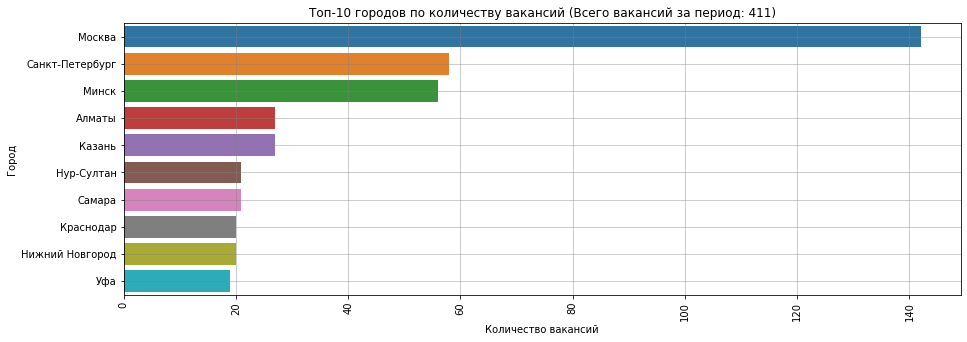

<Figure size 360x360 with 0 Axes>

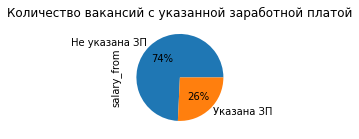

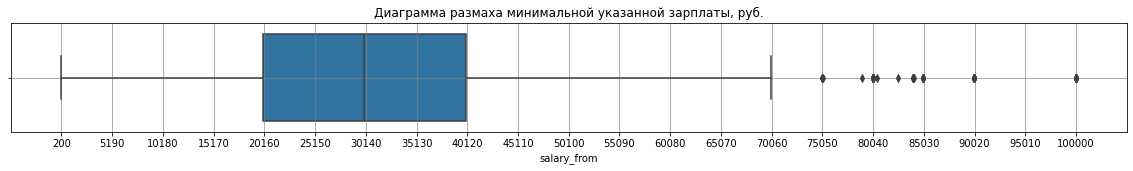

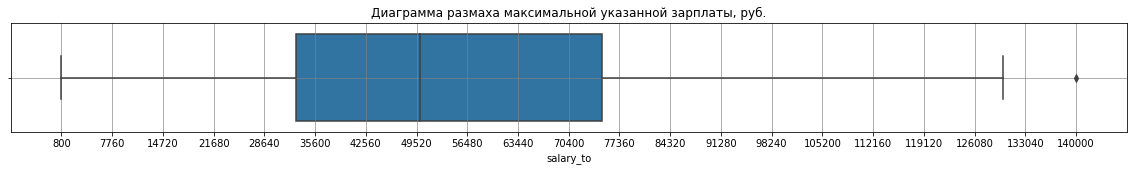

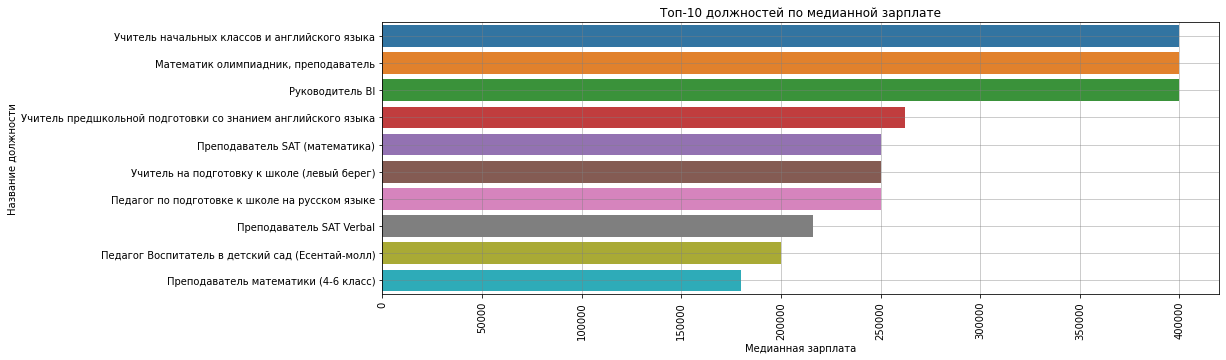

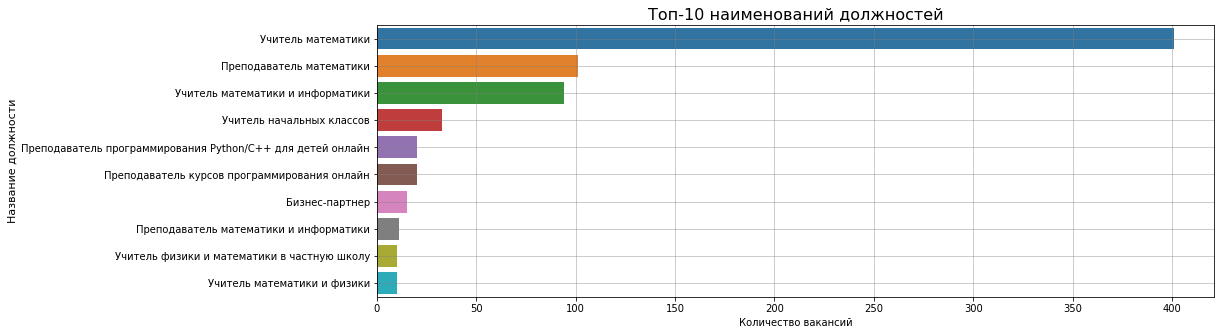

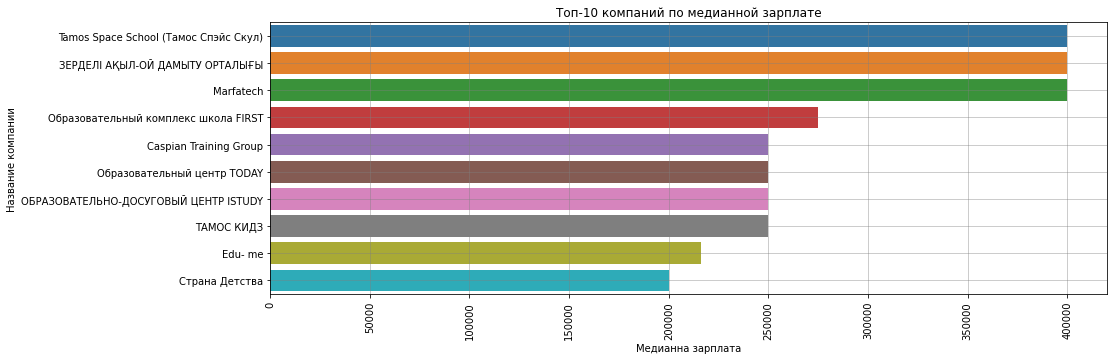

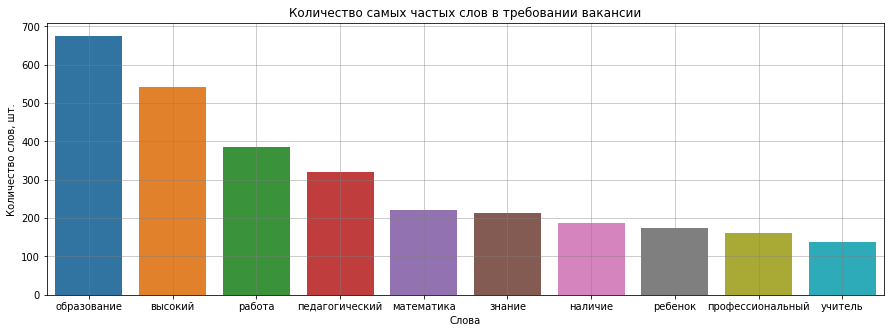

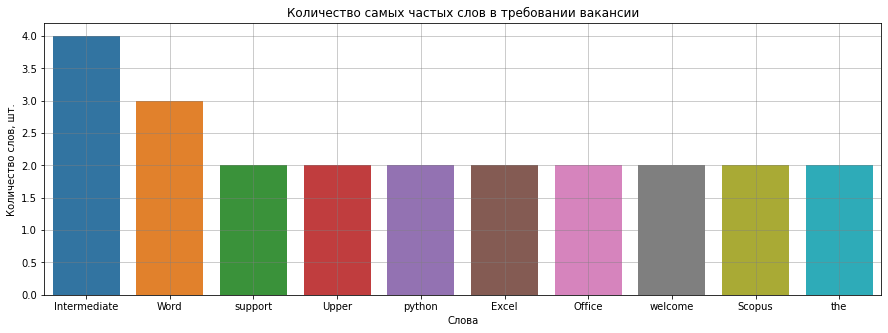

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,ЗЕРДЕЛІ АҚЫЛ-ОЙ ДАМЫТУ ОРТАЛЫҒЫ,"Математик олимпиадник, преподаватель",https://hh.ru/vacancy/67294077,800000.0
1,Кубенов Е.З.,Преподаватель математики,https://hh.ru/vacancy/67695563,600000.0
2,Tamos Space School (Тамос Спэйс Скул),Учитель математики,https://hh.ru/vacancy/67897187,550000.0
3,Образовательный комплекс школа FIRST,Учитель предшкольной подготовки со знанием английского языка,https://hh.ru/vacancy/67387540,520000.0
4,Образовательный комплекс школа FIRST,Учитель начальных классов и английского языка,https://hh.ru/vacancy/67476377,520000.0
5,Абдигазиева М.Ж.,Преподаватель математики,https://hh.ru/vacancy/67903237,500000.0
6,Marfatech,Руководитель BI,https://hh.ru/vacancy/67552159,500000.0
7,ABGroup,Преподаватель математики,https://hh.ru/vacancy/67744577,500000.0
8,Invictus Astana,Учитель математики,https://hh.ru/vacancy/67593659,450000.0
9,Образовательный комплекс школа FIRST,Учитель предшкольной подготовки со знанием английского языка,https://hh.ru/vacancy/67472555,430000.0


Анти топ


,employer_name,name,alternate_url,salary_to
600,ГУО Гимназия №7 г.Минска,Учитель математики,https://hh.ru/vacancy/67333122,1200.0
601,Средняя школа №179 г.Минска,Учитель математики и информатики,https://hh.ru/vacancy/67982532,1100.0
602,Школа робототехники / ROBOLAB,Преподаватель/Репетитор по математике,https://hh.ru/vacancy/67509968,1000.0
603,Средняя школа №139 г. Минска,Учитель информатики / математики / инженер-программист,https://hh.ru/vacancy/67920386,1000.0
604,СРЕДНЯЯ ШКОЛА № 34 г.Минска,Учитель математики,https://hh.ru/vacancy/54896181,1000.0
605,Средняя школа №96 г.Минска,Учитель математики,https://hh.ru/vacancy/67285100,1000.0
606,Филиал БНТУ Минский государственный технологический колледж,Преподаватель математики,https://hh.ru/vacancy/66621252,1000.0
607,MIRZO-ZIYO,Учителя по математике,https://hh.ru/vacancy/67243031,1000.0
608,ГУО Гимназия №50 г.Минска,Учитель математики,https://hh.ru/vacancy/66814001,850.0
609,Гимназия № 11 г. Минска имени И.Д. Черняховского,Учитель математики,https://hh.ru/vacancy/67329409,800.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(teacher, 30)
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_teacher.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

In [ ]:
table_top_salary_company(df, 100).to_excel('math_all.xls')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


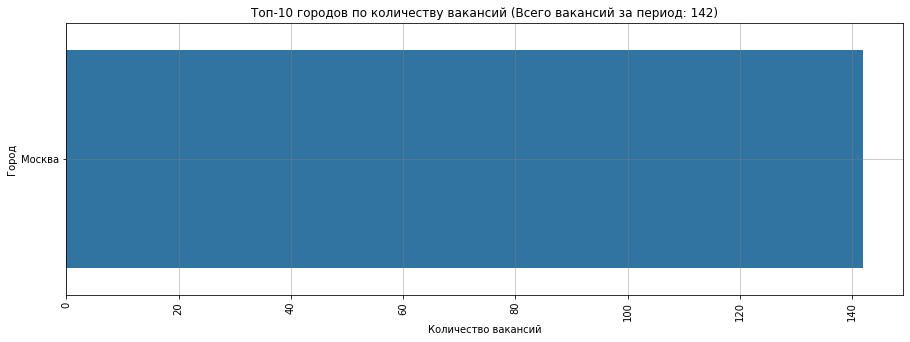

<Figure size 360x360 with 0 Axes>

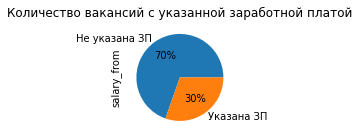

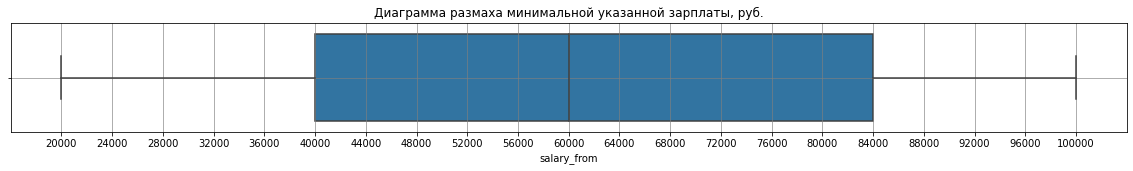

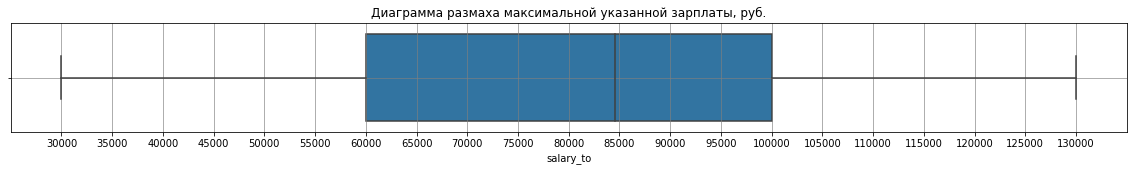

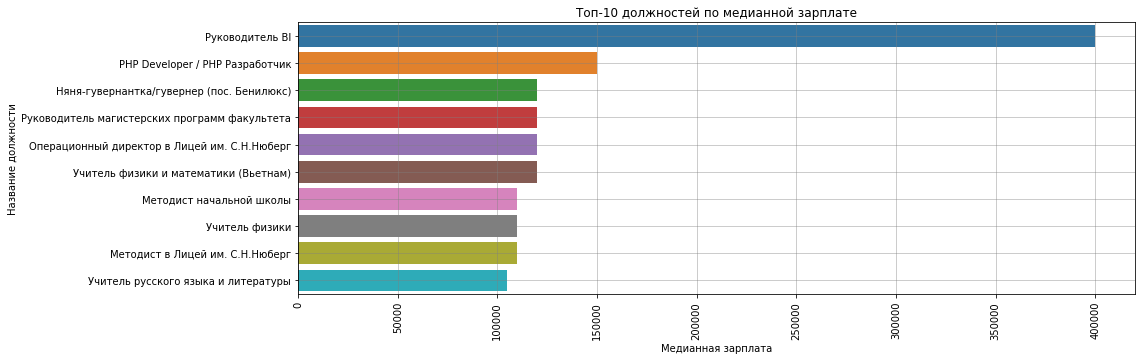

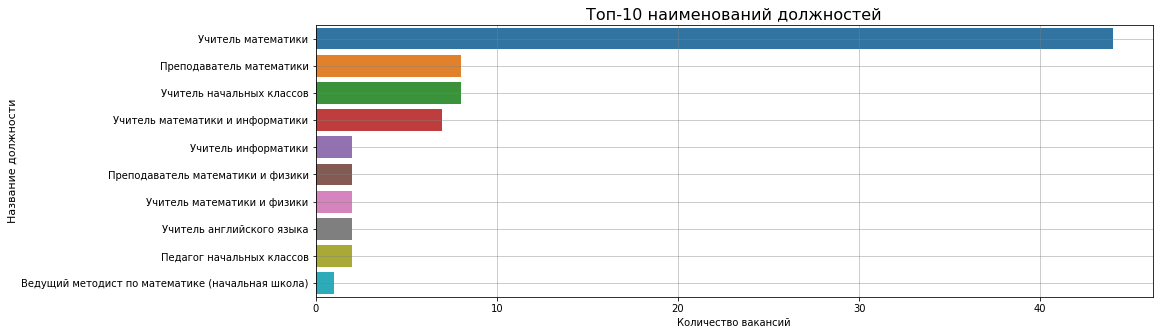

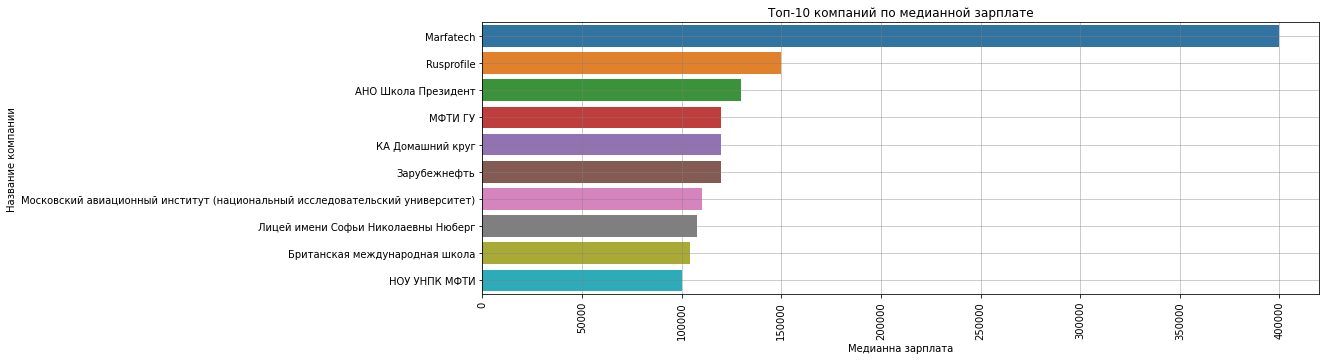

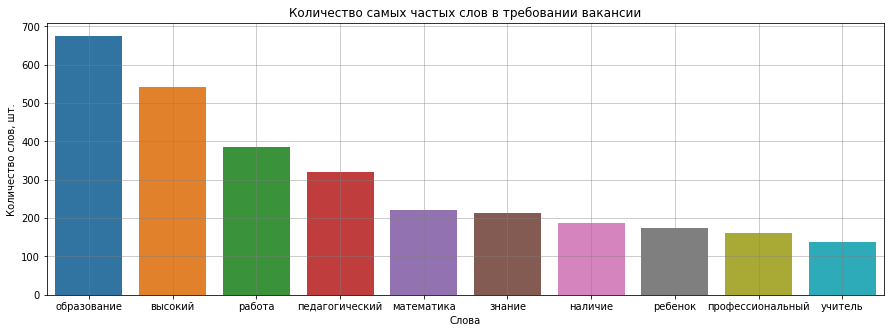

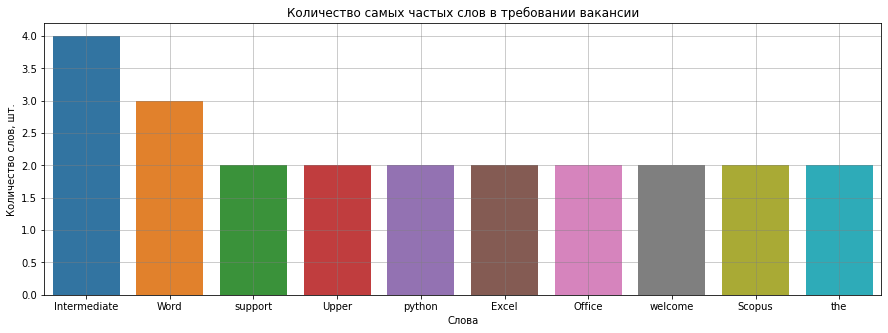

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,Marfatech,Руководитель BI,https://hh.ru/vacancy/67552159,500000.0
1,Rusprofile,PHP Developer / PHP Разработчик,https://hh.ru/vacancy/55867749,300000.0
2,Финансовый университет при Правительстве РФ,Доцент Департамента анализа данных и машинного обучения,https://hh.ru/vacancy/53555736,250000.0
3,Лицей имени Софьи Николаевны Нюберг,Операционный директор в Лицей им. С.Н.Нюберг,https://hh.ru/vacancy/67841373,200000.0
4,ФГБОУ ВО РГАИС,Преподаватель математики и информатики,https://hh.ru/vacancy/67161732,160000.0
5,КА Домашний круг,Няня-гувернантка/гувернер (пос. Бенилюкс),https://hh.ru/vacancy/66694925,150000.0
6,Егэ-Центр,Преподаватель информатики/математики (подготовка к ЕГЭ),https://hh.ru/vacancy/67918991,150000.0
7,Студворк,Автор студенческих работ (по техническим дисциплинам),https://hh.ru/vacancy/53270396,150000.0
8,Школа Академия Знаний,Учитель информатики и математики / руководитель проекта по программированию,https://hh.ru/vacancy/67998339,140000.0
9,ГБОУ школа СВАО,Учитель математики,https://hh.ru/vacancy/67097076,130000.0


Анти топ


,employer_name,name,alternate_url,salary_to
73,Инглиш Лайт,Учитель математики для школьников 5- 11 классов,https://hh.ru/vacancy/67120838,50000.0
74,ТЕХНИКУМ,Педагог нулевого класса (Подготовка к школе),https://hh.ru/vacancy/67337748,50000.0
75,Онлайн-школа Тетрика,Методист вводного онлайн-урока по математике для 1-4 классов (удаленно),https://hh.ru/vacancy/66861838,50000.0
76,Онлайн-школа Тетрика,Методист вводного онлайн-урока по математике для 5-11 классов (удаленно),https://hh.ru/vacancy/66860614,50000.0
77,Клуб Оранжевая Кошка,Учитель начальных классов / Монтессори педагог для детей 6-9 лет,https://hh.ru/vacancy/67708316,45000.0
78,InternetUrok,Учитель математики в онлайн-школе,https://hh.ru/vacancy/67338452,40000.0
79,InternetUrok,Преподаватель математики в онлайн-школе,https://hh.ru/vacancy/67349904,40000.0
80,Романов Дмитрий Алексеевич,Координатор учебного центра (удаленная работа),https://hh.ru/vacancy/67822638,30000.0
81,Романов Дмитрий Алексеевич,Координатор учебного центра (удаленно),https://hh.ru/vacancy/67831737,30000.0
82,Романов Дмитрий Алексеевич,Куратор онлайн школы,https://hh.ru/vacancy/67822492,30000.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(teacher, 30)
df = df[df['city'] == 'Москва']
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_teacher_msk.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

In [ ]:
table_top_salary_company(df, 100).to_excel('math.xls')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


### Конструктор 

In [ ]:
design_engineer = f"'Инженер конструктор' or 'Конструктор'"

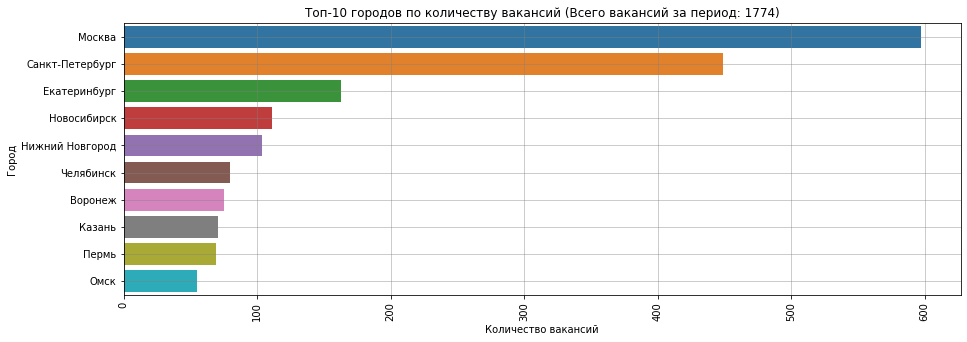

<Figure size 360x360 with 0 Axes>

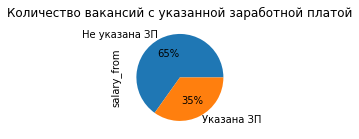

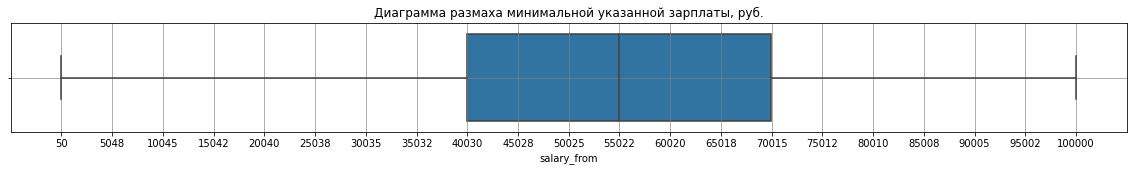

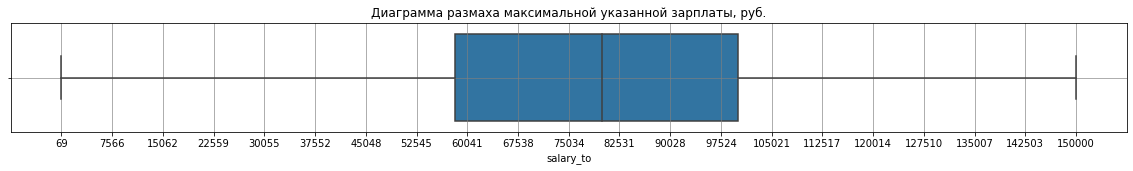

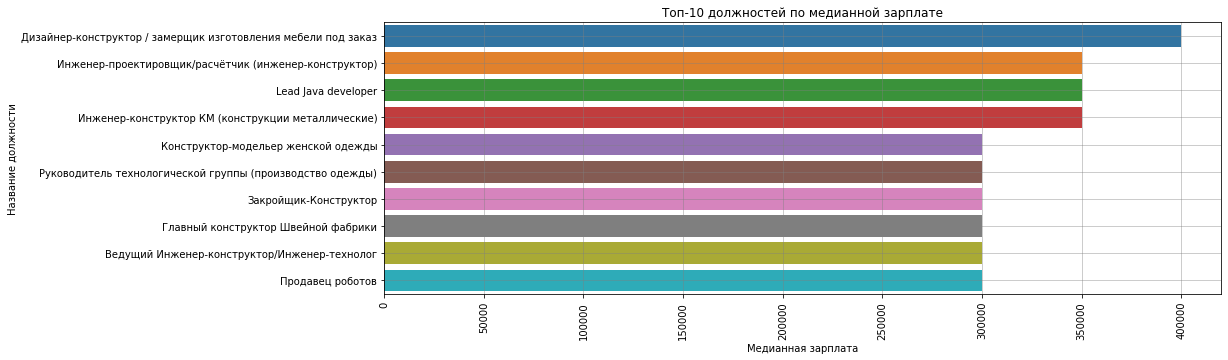

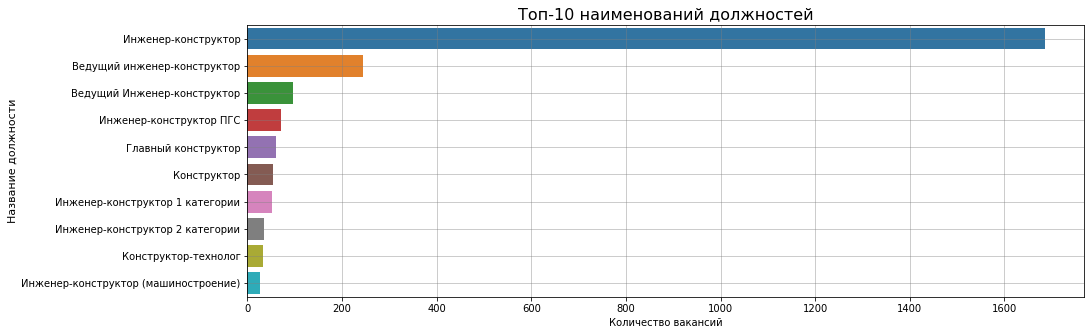

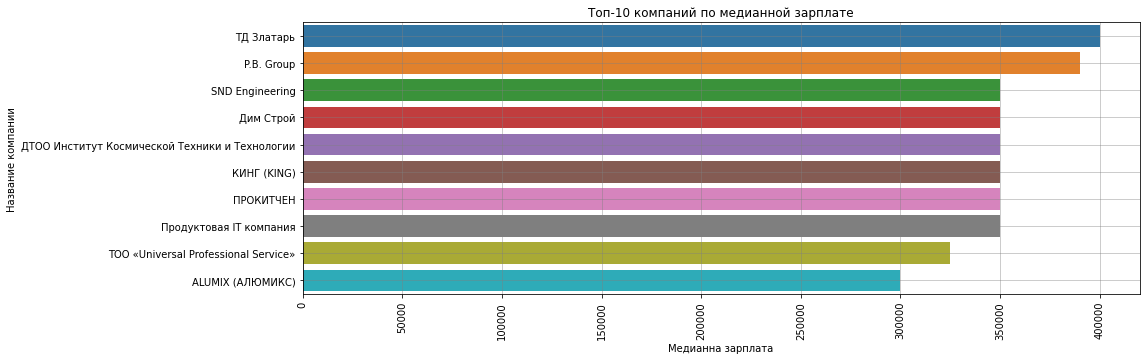

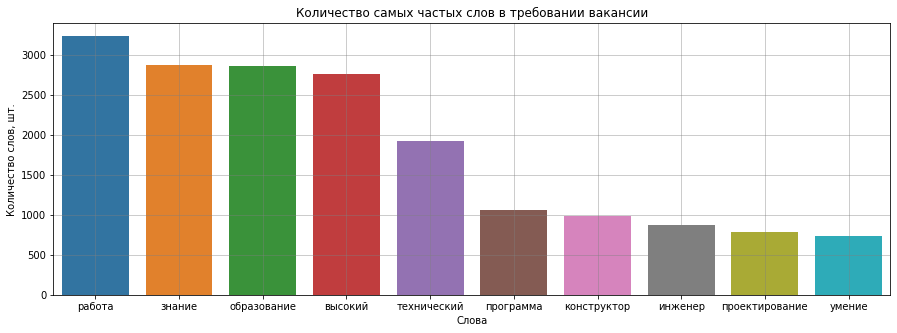

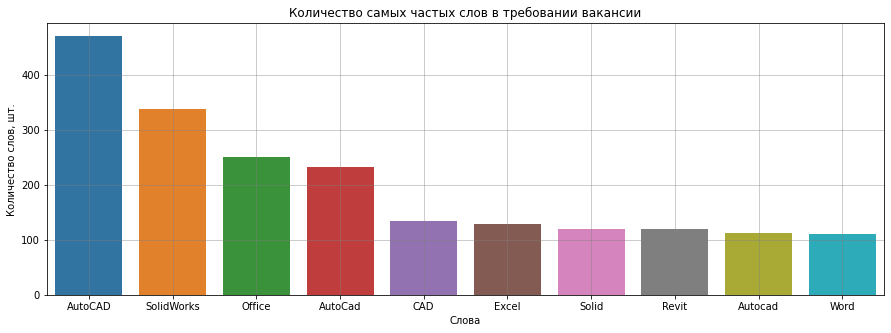

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,TOO «Universal Professional Service»,Дизайнер-конструктор / замерщик изготовления мебели под заказ,https://hh.ru/vacancy/67519751,1000000.0
1,АЛМАТЫЭНЕРГОСЕРВИС,Ведущий Инженер-конструктор,https://hh.ru/vacancy/67573229,900000.0
2,КОНТУР ПРОЕКТ,"Главный инженер проекта, проектировщик",https://hh.ru/vacancy/67734629,850000.0
3,TOO «Universal Professional Service»,Технолог-конструктор мебельного производства,https://hh.ru/vacancy/67658674,700000.0
4,Sara Fashion Group,Закройщик-Конструктор,https://hh.ru/vacancy/67734393,600000.0
5,"Premium Fabric, ТМ (Каримова, ИП)",Конструктор-модельер женской одежды,https://hh.ru/vacancy/67682232,550000.0
6,ТЭРРА Компани,Дизайнер-конструктор,https://hh.ru/vacancy/68018979,500000.0
7,Астанинский технологический центр,Ведущий Инженер-конструктор/Инженер-технолог,https://hh.ru/vacancy/67691061,500000.0
8,Дим Строй,Инженер-проектировщик/расчётчик (инженер-конструктор),https://hh.ru/vacancy/67844182,500000.0
9,SND Engineering,Инженер-конструктор,https://hh.ru/vacancy/67761179,500000.0


Анти топ


,employer_name,name,alternate_url,salary_to
1772,Шушкевич М. А.,Инженер-конструктор,https://hh.ru/vacancy/67904775,1500.0
1773,Кухни Беларуси,Инженер-конструктор (технолог) мебельного производства,https://hh.ru/vacancy/67717393,1400.0
1774,Ольса,Ведущий инженер-конструктор,https://hh.ru/vacancy/67973611,1350.0
1775,АМКОДОР - управляющая компания холдинга,Ведущий инженер-конструктор,https://hh.ru/vacancy/68016639,1200.0
1776,Ананько Н. А.,Закройщик-конструктор,https://hh.ru/vacancy/67804714,1000.0
1777,"ГОРОДНИЧИЙ, ЧП",Обмерщик помещений,https://hh.ru/vacancy/66103727,800.0
1778,Woodline,Консультант-конструктор (дизайнер) мебели на заказ,https://hh.ru/vacancy/67898359,600.0
1779,ProjectCityGroup,Ведущий Инженер-конструктор,https://hh.ru/vacancy/67667369,120.0
1780,Оберон-Альфа,Инженер-конструктор,https://hh.ru/vacancy/67624359,80.0
1781,Expertum group,"Ведущий Инженер-конструктор, заместитель руководителя конструкторского отдела, инженер-конструктор.",https://hh.ru/vacancy/67592024,69.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(design_engineer, 30)
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_design_engineer.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)

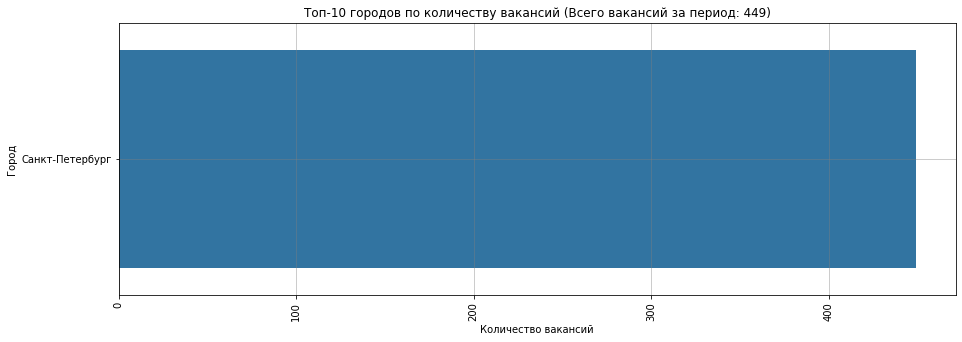

<Figure size 360x360 with 0 Axes>

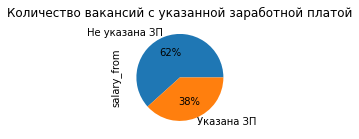

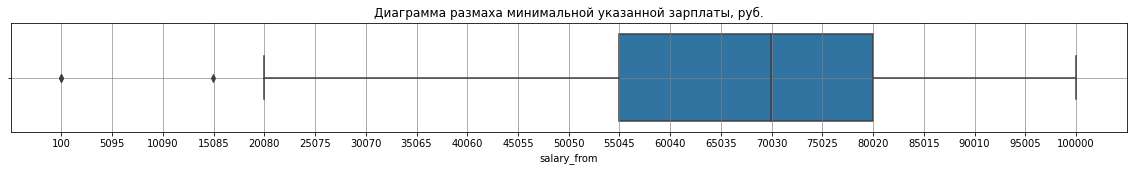

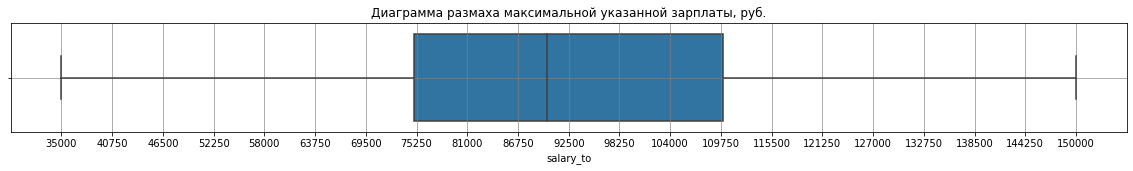

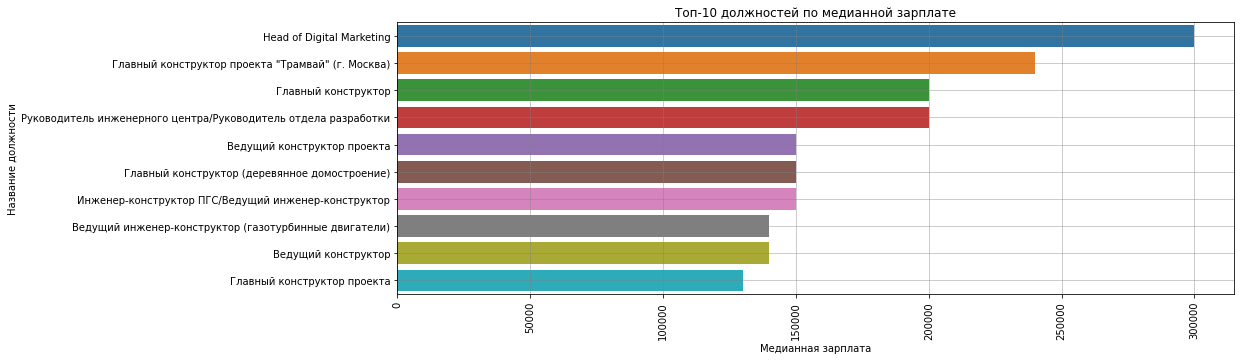

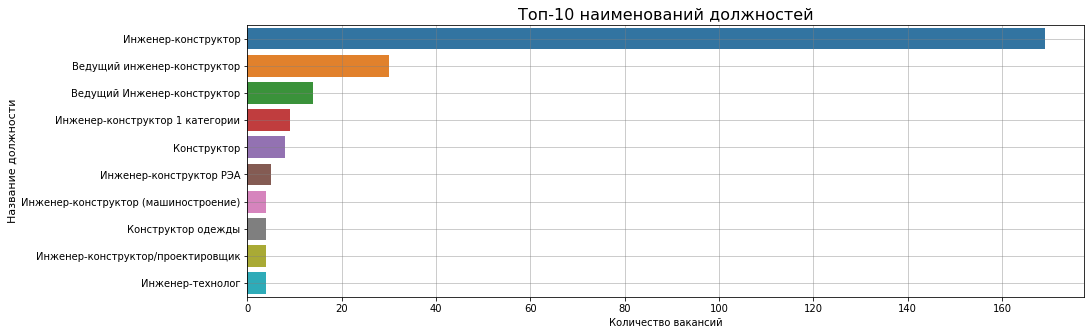

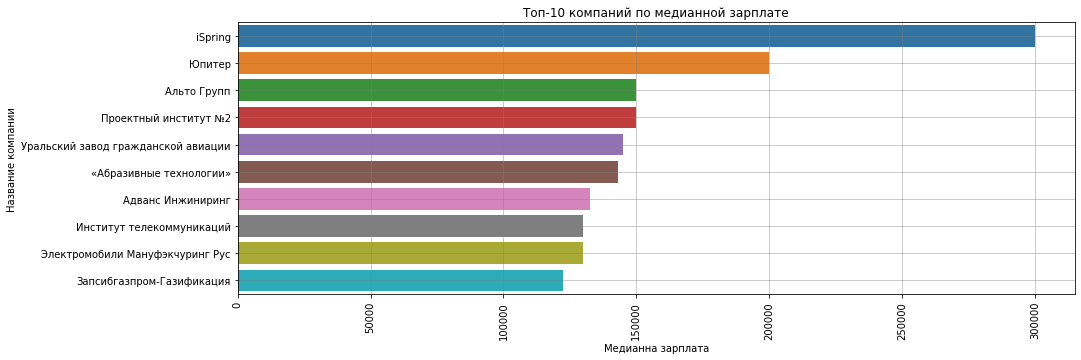

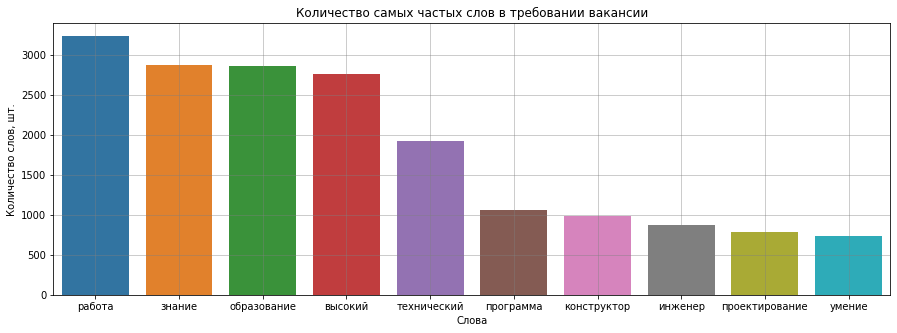

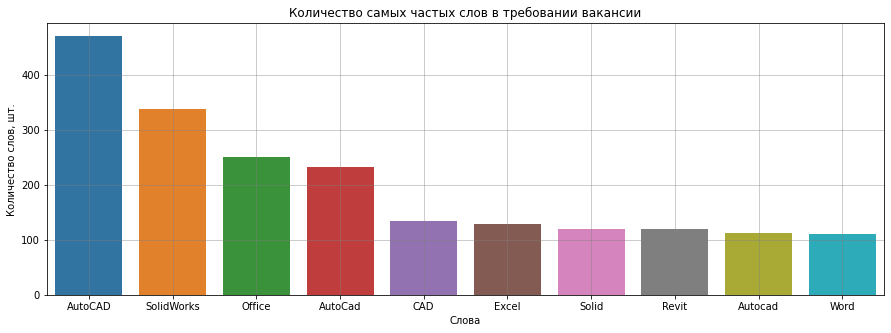

Топ вакансий


,employer_name,name,alternate_url,salary_to
0,СтройЭксперт,Главный инженер проекта,https://hh.ru/vacancy/67589875,280000.0
1,BK Engineering,Инженер-конструктор СПК и/или НВФ,https://hh.ru/vacancy/67755216,200000.0
2,Архпроект,Инженер-конструктор,https://hh.ru/vacancy/67584767,200000.0
3,Охтинский Механический Завод,Инженер-конструктор,https://hh.ru/vacancy/67889014,200000.0
4,Охтинский Механический Завод,Инженер-конструктор,https://hh.ru/vacancy/67168550,200000.0
5,Аркада-строй,Инженер-конструктор Алюминиевых витражей и окон,https://hh.ru/vacancy/67385693,200000.0
6,Невский инструментальный завод,Ведущий инженер-конструктор / Заместитель главного конструктора,https://hh.ru/vacancy/67266870,180000.0
7,ЛенЭкспертПроект,Главный конструктор / Ведущий конструктор / Инженер-конструктор КЖ,https://hh.ru/vacancy/66879905,175000.0
8,Группа ЛСР,Инженер-конструктор I категории,https://hh.ru/vacancy/55892316,175000.0
9,Группа ЛСР,Ведущий инженер-конструктор (конструкторский отдел),https://hh.ru/vacancy/55891541,175000.0


Анти топ


,employer_name,name,alternate_url,salary_to
221,Светлана-Электронприбор,Инженер конструктор (возможно обучение),https://hh.ru/vacancy/67280252,50000.0
222,Винета,Инженер-конструктор по разработке тары и упаковки,https://hh.ru/vacancy/67301461,50000.0
223,PRO Взгляд,Работник производства,https://hh.ru/vacancy/67995509,50000.0
224,Промфильтркомплект,Инженер-конструктор (начинающий специалист),https://hh.ru/vacancy/67516488,50000.0
225,Группа Полипластик,Инженер-конструктор,https://hh.ru/vacancy/67436860,45000.0
226,Робикс,Преподаватель робототехники для детей,https://hh.ru/vacancy/67654406,40000.0
227,Артемьев Дмитрий Дмитриевич,Менеджер интернет-магазина Lego (удаленно),https://hh.ru/vacancy/67891468,40000.0
228,ГК Евб,Специалист по контекстной рекламе,https://hh.ru/vacancy/67362409,40000.0
229,Тайм Триал,Помощник конструктора надувного оборудования,https://hh.ru/vacancy/67296170,40000.0
230,BestDoctor,Медицинский регистратор (удаленно),https://hh.ru/vacancy/67652246,35000.0


In [ ]:
df, df_lemma_ru, df_lemma_en, df_msk, df_msk_3_years = parse_vanacy_name(design_engineer, 30)
df = df[df['city'] == 'Санкт-Петербург']
dt_now = datetime.now().date()
df.to_csv(f"/content/drive/MyDrive/projects/analysis_open_vacancies_headhunter/dumps/{dt_now}_design_engineer_msk.csv")
top_city(df, 10)
with_salary(df)
tail_salary_boxplot(df)
top_salary_boxplot(df)
top_salary(df, 10)
top_proff(df, 10)
top_company(df, 10)
top_words(df_lemma_ru)
top_words(df_lemma_en)
print('Топ вакансий')
display(table_top_salary_company(df, 10))
print('Анти топ')
table_antitop_salary_company(df, 10)